In [2]:
import ast
import glob
import json
import os
import re
import sys
import time
from functools import partial

import ipywidgets as widgets
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import BoundaryNorm, SymLogNorm
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d
from scipy.ndimage import generate_binary_structure, iterate_structure, minimum_filter
from scipy.signal import argrelextrema
from scipy.special import expit
from torch.autograd import grad
from torch.autograd.functional import hessian, jacobian
from torch.func import jacrev, vmap
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from tqdm import trange

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

from src.dataloader import FastTensorDataLoader

In [3]:
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Preparation

In [3]:
def parse_filename(filename):
    if "sftcr" in filename:
        process_type = "sftcr"
        pattern = r'kappa([0-9.]+)_sigma([0-9.]+)'
    elif "lj" in filename:
        process_type = "lj"
        pattern = r'epsilon([0-9.]+)_sigma([0-9.]+)'
    else:
        process_type = None
        pattern = None

    kappa_or_epsilon = None
    sigma = None
    if pattern:
        match = re.search(pattern, filename)
        if match:
            kappa_or_epsilon = torch.tensor(float(match.group(1)))
            sigma = torch.tensor(float(match.group(2)))

    if "inhom" in filename:
        homogeneous = False
    elif "hom" in filename:
        homogeneous = True
    else:
        homogeneous = None

    return kappa_or_epsilon, sigma, homogeneous, process_type

In [4]:
files = sorted(glob.glob("simulations/*.csv"))
file_selector = widgets.Dropdown(
    options=files,
    value=files[6],  # default
    description='Dataset:',
    layout=widgets.Layout(width='80%')
)

selected_filename = {"value": file_selector.value}

def on_file_change(change):
    if change["name"] == "value":
        selected_filename["value"] = change["new"]
        print(f"Selected file: {selected_filename['value']}")

file_selector.observe(on_file_change, names='value')
display(file_selector)

Dropdown(description='Dataset:', index=6, layout=Layout(width='80%'), options=('simulations/simulated_points_l…

In [6]:
filename = selected_filename["value"]
df = pd.read_csv(filename)
parameter, sigma, homogeneous, process = parse_filename(filename)

if process == "sftcr":
    k = parameter.clone()
else:
    epsilon = parameter.clone()
scale = torch.tensor(0.5)

samples = [
    torch.tensor(group[["x", "y"]].values, dtype=torch.float32, device=device) 
    for _, group in df.groupby("sim")
]
samples = tuple(samples)[:10]

In [17]:
test_size_widget = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=0.9,
    step=0.05,
    description='Test size:',
    continuous_update=False,
    readout_format='.2f'
)

batch_size_widget = widgets.IntSlider(
    value=32,
    min=1,
    max=512,
    step=1,
    description='Batch size:',
    continuous_update=False
)

display(test_size_widget, batch_size_widget)

# Global storage
saved_params = {
    "test_size": test_size_widget.value,
    "batch_size": batch_size_widget.value,
    "loader_train": None,
    "loader_test": None
}

# Update function
def on_widget_change(change):
    if change["name"] == "value":
        saved_params["test_size"] = test_size_widget.value
        saved_params["batch_size"] = batch_size_widget.value

        train_ratio = 1 - saved_params["test_size"]
        
        X = pad_sequence(samples, batch_first=True, padding_value=0)
        lengths = torch.tensor([len(s) for s in samples], dtype=torch.int64, device=device)
        lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
        X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

        m = len(X)
        train_size = int(train_ratio * m)
        X_train = X[:train_size]
        X_test = X[train_size:]

        loader_train = FastTensorDataLoader(X_train, batch_size=saved_params["batch_size"], shuffle=False)
        loader_test = FastTensorDataLoader(X_test, batch_size=saved_params["batch_size"], shuffle=False)

        saved_params["loader_train"] = loader_train
        saved_params["loader_test"] = loader_test

        print(f"[Updated] Train size: {len(X_train)}, Test size: {len(X_test)}, Batch size: {saved_params['batch_size']}")

# Attach observers
test_size_widget.observe(on_widget_change, names="value")
batch_size_widget.observe(on_widget_change, names="value")

on_widget_change({"name": "value", "new": test_size_widget.value})

FloatSlider(value=0.0, continuous_update=False, description='Test size:', max=0.9, step=0.05)

IntSlider(value=32, continuous_update=False, description='Batch size:', max=512, min=1)

[Updated] Train size: 10, Test size: 0, Batch size: 32


In [18]:
loader_train = saved_params["loader_train"]
loader_test = saved_params["loader_test"]
batch_size = saved_params["batch_size"]
test_size = saved_params["test_size"]

In [19]:
for X_batch in loader_train:
    points = X_batch[0]
points.requires_grad_()

tensor([[[-9.5586e-01,  4.7007e-01,  8.2000e+01],
         [-6.6701e-01,  8.6940e-01,  8.2000e+01],
         [ 3.7623e-01, -6.5475e-01,  8.2000e+01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  8.2000e+01],
         [ 0.0000e+00,  0.0000e+00,  8.2000e+01],
         [ 0.0000e+00,  0.0000e+00,  8.2000e+01]],

        [[-5.2826e-01,  1.9771e-01,  7.6000e+01],
         [ 2.8814e-02,  1.4412e-01,  7.6000e+01],
         [-9.1432e-01,  8.3842e-01,  7.6000e+01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  7.6000e+01],
         [ 0.0000e+00,  0.0000e+00,  7.6000e+01],
         [ 0.0000e+00,  0.0000e+00,  7.6000e+01]],

        [[-8.1532e-01, -2.9101e-01,  8.1000e+01],
         [-2.0686e-01,  3.3862e-01,  8.1000e+01],
         [ 1.1759e-01,  3.1205e-01,  8.1000e+01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  8.1000e+01],
         [ 0.0000e+00,  0.0000e+00,  8.1000e+01],
         [ 0.0000e+00,  0.0000e+00,  8.1000e+01]],

        ...,

        [[ 5.0160e-01,  8.2620e-01,  8

In [20]:
def parse_and_exp(array):
    parsed = []
    for item in array:
        if isinstance(item, str):
            val = ast.literal_eval(item)
            parsed.append(np.exp(val[0]))
        elif isinstance(item, list) or isinstance(item, np.ndarray):
            parsed.append(np.exp(item[0]))
        else:
            parsed.append(np.exp(item))
    return parsed

def parse_and_sigmoid(array):
    parsed = []
    for item in array:
        if isinstance(item, str):
            val = ast.literal_eval(item)
            parsed.append(expit(val[0]))
        elif isinstance(item, list) or isinstance(item, np.ndarray):
            parsed.append(expit(item[0]))
        else:
            parsed.append(expit(item))
    return parsed

def parse(array):
    parsed = []
    for item in array:
        if isinstance(item, str):
            val = ast.literal_eval(item)
            parsed.append(val[0])
        elif isinstance(item, list) or isinstance(item, np.ndarray):
            parsed.append(item[0])
        else:
            parsed.append(item)
    return parsed

def clip_to_bounds(x, y, xlim, ylim):
        x_clipped = min(max(x, xlim[0]), xlim[1])
        y_clipped = min(max(y, ylim[0]), ylim[1])
        return x_clipped, y_clipped

def get_min_distances(samples):
    min_dists = []
    for points in samples:
        if len(points) < 2:
            continue
        dist_matrix = torch.cdist(points, points)
        min_dist = torch.min(dist_matrix + torch.eye(len(points), device=device) * 1e6)  # exclude self
        # Adjust with n/(n+1)
        min_dists.append(min_dist.item() * len(points) / (len(points) + 1))

    return min_dists

## Softcore

In [16]:
class Gibbs_Softcore(nn.Module):
    def __init__(self, homogeneous=True, canonical=False, fixed_k=0.5, K=None, initial_sigma=None, device='cpu'):
        super().__init__()
        torch.manual_seed(123)
        torch.cuda.manual_seed(123)

        self.homogeneous = homogeneous
        self.canonical = canonical
        self.fixed_k = fixed_k
        self.K = K
        self.device = device

        if not self.homogeneous:
            self.scale_raw = nn.Parameter(torch.log(torch.rand(1, device=device)))

        if canonical:
            sigma_raw = torch.tensor([initial_sigma], device=device)
            self.gamma = nn.Parameter(sigma_raw**(2/k))
        else:
            self.sigma_raw = nn.Parameter(torch.log(torch.tensor([initial_sigma], device=device)))
            self.k_raw = nn.Parameter(torch.rand(1, device=device))

    @property
    def scale(self):
        return torch.exp(self.scale_raw)

    @property
    def sigma(self):
        return torch.exp(self.sigma_raw) if not self.canonical else None

    @property
    def k(self):
        if self.canonical:
            return self.fixed_k
        return torch.sigmoid(self.k_raw)

    def forward(self, x, mask):
        _, N, _ = x.shape
        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=x.device)

        xi, xj = x[:, i_idx, :], x[:, j_idx, :]
        diff = xi - xj
        r = torch.sqrt((diff ** 2).sum(dim=-1) + 1e-10)

        mask_i, mask_j = mask[:, i_idx], mask[:, j_idx]
        pairwise_mask = mask_i & mask_j

        phi = torch.zeros_like(r)
        if self.canonical:
            phi[pairwise_mask] = self.gamma * (1 / r[pairwise_mask]) ** (2 / self.k)
        else:
            phi[pairwise_mask] = (self.sigma / r[pairwise_mask]) ** (2 / self.k)

        energy = phi.sum(dim=-1)
        if self.homogeneous:
            return -energy
        return - x.pow(2).sum(dim=-1).sum(dim=-1) / self.scale**2 - energy

    def compute_psi(self, x, mask):
        output = self.forward(x, mask)
        grad_outputs = torch.ones_like(output, device=x.device)
        return torch.autograd.grad(
            output, x, grad_outputs=grad_outputs,
            retain_graph=True, create_graph=True
        )[0]

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64, device=self.device)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]
        mask = torch.arange(max_length, device=self.device).unsqueeze(0) < lengths.unsqueeze(1)

        psi_x = self.compute_psi(x_t, mask)
        norm_squared = psi_x.pow(2).sum(dim=-1) * mask

        B, N, D = x_t.shape
        if self.K:
            divergence = 0
            for _ in range(self.K):
                epsilon = torch.randint(0, 2, x_t.shape, device=self.device).float() * 2 - 1
                eps_psi = (psi_x * epsilon).sum()
                divergence_est = torch.autograd.grad(
                    eps_psi, x_t, create_graph=True
                )[0]
                divergence += (divergence_est * epsilon).sum(dim=-1) 
            divergence = (divergence / self.K) * mask
        else:
            divergence = torch.zeros(x_t.shape[0], x_t.shape[1], device=x_t.device)
            for d in range(x_t.shape[-1]):
                for i in range(x_t.shape[-2]):
                    second_grad = torch.autograd.grad(
                        psi_x[:, i, d].sum(), x_t, retain_graph=True, create_graph=True
                    )[0][:, i, d]
                    divergence[:, i] += second_grad
            divergence = divergence * mask

        total_loss = (0.5 * norm_squared + divergence).sum(dim=-1) / lengths 
        return total_loss.mean()

### Original Parameters

In [34]:
K_widget = widgets.FloatText(
    value=None,
    description='K',
    layout=widgets.Layout(width='200px')
)

xmin_widget = widgets.FloatText(
    value=1e-20,
    description='xmin',
    layout=widgets.Layout(width='200px')
)

xmax_widget = widgets.FloatText(
    value=0.8,
    description='xmax',
    layout=widgets.Layout(width='200px')
)

# Y range widgets
ymin_widget = widgets.FloatText(
    value=0.08,
    description='ymin',
    layout=widgets.Layout(width='200px')
)

ymax_widget = widgets.FloatText(
    value=0.16,
    description='ymax',
    layout=widgets.Layout(width='200px')
)

range_box_x = widgets.HBox([xmin_widget, xmax_widget])
range_box_y = widgets.HBox([ymin_widget, ymax_widget])

ui = widgets.VBox([
    K_widget,
    widgets.Label("X range:"),
    range_box_x,
    widgets.Label("Y range:"),
    range_box_y
])

display(ui)

In [19]:
canonical = False
K = K_widget.value if K_widget.value != 0 else None
initial_sigma = torch.tensor(get_min_distances(samples)).mean()
model = Gibbs_Softcore(homogeneous, canonical, K=K, initial_sigma=initial_sigma, device=device)

# Grid setup
xmin, xmax = xmin_widget.value, xmax_widget.value
ymin, ymax = ymin_widget.value, ymax_widget.value

sigma_vals = torch.linspace(ymin, ymax, 25)
log_sigma_vals = torch.log(sigma_vals)
k_vals = torch.linspace(xmin, xmax, 25)

loss_surface = []

# Grid scan with progress bar
for i, k_val in tqdm(enumerate(k_vals), total=len(k_vals), desc="Scanning kappa and sigma values"):
    for j, log_sigma in enumerate(log_sigma_vals):
        sigma_raw = log_sigma
        k_raw = - torch.log(1/k_val - 1)
        
        model.k_raw.data = torch.tensor([k_raw], device=device)
        model.sigma_raw.data = torch.tensor([sigma_raw], device=device)
        
        # Compute loss
        points = points.double()
        loss = model.loss(points)
        try:
            loss_surface.append((sigma_vals[j].item(), k_vals[i].item(), loss.item()))
        except Exception as e:
            loss_surface.append((sigma_vals[j].item(), k_vals[i].item(), float('nan')))

Scanning kappa and sigma values: 100%|██████████| 25/25 [04:30<00:00, 10.83s/it]


/tmp/ipykernel_1620066/1346692661.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


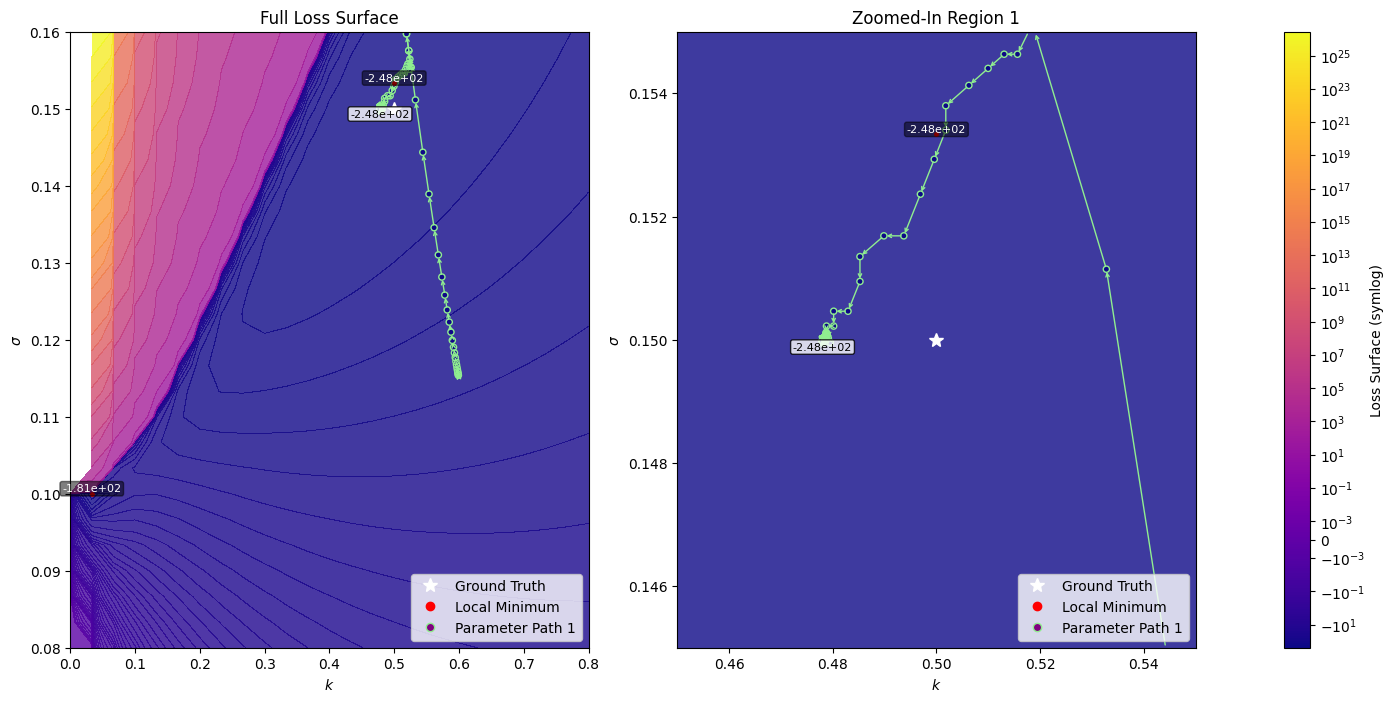

In [26]:
df = pd.DataFrame(loss_surface, columns=["sigma", "k", "loss"])
pivot = df.pivot(index="sigma", columns="k", values="loss")

sigma_vals_np = pivot.index.values
k_vals_np = pivot.columns.values
loss_surface_np = pivot.values
loss_surface_np[np.isinf(loss_surface_np)] = np.nan

E, S = np.meshgrid(k_vals_np, sigma_vals_np)
masked_loss = np.ma.masked_invalid(loss_surface_np)

# Replace masked array with plain array
Z = loss_surface_np  # just use NaN-containing array

# Create color-normalization and level setup
linthresh = 1e-3
vmin = np.nanmin(Z)
vmax = np.nanpercentile(Z, 100)

neg_levels = -np.geomspace(linthresh, -vmin, num=50)
pos_levels = np.geomspace(linthresh, vmax, num=30) if vmax > 0.0 else np.array([])
symlog_levels = np.concatenate((neg_levels[::-1], [0], pos_levels))

# Colormaps and norm
cmap_contour = plt.cm.plasma.copy()
cmap_contour.set_bad(color='red')  # Handle NaNs in the colormap

norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)

path = f"simulation_results/*kappa*sigma{sigma:.2f}_hom_larger_window_results_canonical_False_initial_sigma.json"
num_paths = len(glob.glob(path))

# Define a list of marker styles
markers = ['o', '^', 's', 'D', 'v', 'P', '*', 'X']  # Extend as needed
edge_color = 'lightgreen'

base = generate_binary_structure(2, 2) 
neighborhood = iterate_structure(base, 1)
local_min = (Z == minimum_filter(Z, footprint=neighborhood, mode='wrap'))
local_min[np.isnan(Z)] = False
local_min_coords = np.argwhere(local_min)

# Define two zoom regions
zoom1_xmin, zoom1_xmax =  0.45, 0.55
zoom1_ymin, zoom1_ymax = 0.145, 0.155

zoom2_xmin, zoom2_xmax = 0.45, 0.55
zoom2_ymin, zoom2_ymax = 0.1, 0.11

# Setup figure with three subplots side by side
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.25)

# Axes
ax = fig.add_subplot(gs[0])    # Full
ax2 = fig.add_subplot(gs[1])   # Zoom 1
#ax3 = fig.add_subplot(gs[2])   # Zoom 2
cax = fig.add_subplot(gs[2])   # Colorbar

# Plot on all three axes
for axis, xlim, ylim, title in [
    (ax, (k_vals_np[0], k_vals_np[-1]), (sigma_vals_np[0], sigma_vals_np[-1]), "Full Loss Surface"),
    (ax2, (zoom1_xmin, zoom1_xmax), (zoom1_ymin, zoom1_ymax), "Zoomed-In Region 1"),
    #(ax3, (zoom2_xmin, zoom2_xmax), (zoom2_ymin, zoom2_ymax), "Zoomed-In Region 2"),
]:
    cs = axis.contourf(E, S, loss_surface_np, levels=symlog_levels, cmap=cmap_contour, norm=norm, alpha=0.8)
    axis.set_xlim(*xlim)
    axis.set_ylim(*ylim)
    axis.set_title(title)
    axis.set_xlabel("$k$")
    axis.set_ylabel("$\sigma$")

    if axis == ax:
        legend_elements = [
            Line2D([0], [0], marker='*', color='white', label='Ground Truth', linestyle='', markersize=10),
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]
    elif axis == ax2:
        legend_elements = [
            Line2D([0], [0], marker='*', color='white', label='Ground Truth', linestyle='', markersize=10),
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]
    else:
        legend_elements = [
            Line2D([0], [0], marker='*', color='white', label='Ground Truth', linestyle='', markersize=10),
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]

    for idx, filename in enumerate(glob.glob(path), start=1):
        with open(filename, 'r') as f:
            data = json.load(f)
        path_ks = parse_and_sigmoid(data["param_history"]['k_raw'])
        path_sigmas = parse_and_exp(data["param_history"]['sigma_raw'])
        losses = data['avg_epoch_losses']
        # Add training paths and local minima
        def clip_to_bounds(x, y, xlim, ylim):
            x_clipped = min(max(x, xlim[0]), xlim[1])
            y_clipped = min(max(y, ylim[0]), ylim[1])
            return x_clipped, y_clipped

        # Choose marker shape by index and set fixed edge color
        marker_style = markers[(idx - 1) % len(markers)]
        sc = axis.scatter(path_ks, path_sigmas, c=losses, cmap=cmap_contour, norm=norm,
                  edgecolor=edge_color, marker=marker_style, s=20)

        if axis == ax2 and idx==1:
            legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
                   markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        #elif axis == ax3 and idx==2:
        #    legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
        #           markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        elif axis == ax:
            legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
                   markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        for i in range(1, len(path_ks)):
            x0, y0 = path_ks[i - 1], path_sigmas[i - 1]
            x1, y1 = path_ks[i], path_sigmas[i]
         
            # Only draw if at least part of the arrow is in bounds
            if ((xlim[0] <= x0 <= xlim[1] or xlim[0] <= x1 <= xlim[1]) and
                (ylim[0] <= y0 <= ylim[1] or ylim[0] <= y1 <= ylim[1])):
                
               # Clip start point to boundary if it's outside
                if not (xlim[0] <= x0 <= xlim[1] and ylim[0] <= y0 <= ylim[1]):
                    x0, y0 = clip_to_bounds(x0, y0, xlim, ylim)
                if not (xlim[0] <= x1 <= xlim[1] and ylim[0] <= y1 <= ylim[1]):
                    x1, y1 = clip_to_bounds(x1, y1, xlim, ylim)
        
                axis.annotate("",
                    xy=(x1, y1), xytext=(x0, y0),
                    arrowprops=dict(arrowstyle="->", color=edge_color, lw=1),
                    size=6, zorder=1)
        if xlim[0] < path_ks[-1] < xlim[1] and ylim[0] < path_sigmas[-1] < ylim[1]:
            axis.text(path_ks[-1], path_sigmas[-1]-0.00002, f"{losses[-1]:.2e}", color='black', fontsize=8,
                      ha='center', va='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))
            
    
    axis.legend(handles=legend_elements, loc='lower right', framealpha=0.8)
    
    # Add local minima
    #if axis != ax:
    for i, j in local_min_coords:
        x = k_vals_np[j]
        y = sigma_vals_np[i]
        loss_val = Z[i, j]
        if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
            axis.plot(x, y, marker='.', color='red', markersize=5)
            #if axis != ax:
            axis.text(x, y, f"{loss_val:.2e}", color='white', fontsize=8,
                          ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    # Ground truth
    axis.plot(k, sigma, marker='*', color='white', markersize=10)

# Colorbar
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label("Loss Surface (symlog)")

fig.tight_layout()
plt.show()

### Canonical Parameters

In [53]:
canonical = True
K=None
model = Gibbs_Softcore(homogeneous, canonical, K=K, device=device)

xmin, xmax = 1e-10, 0.1
gamma_vals = torch.linspace(xmin, xmax, 100)

loss_surface = []

# Grid scan with progress bar
for i, gamma_val in tqdm(enumerate(gamma_vals), total=len(gamma_vals), desc="Scanning gamma values"):
    model.gamma.data = torch.tensor([gamma_val], device=device)
    if not homogeneous:
        model.scale_raw.data = torch.tensor([-2.05130351606], device=device)
    
    # Compute loss
    loss = model.loss(points)
    try:
        loss_surface.append((gamma_vals[i].item(), loss.item()))
    except Exception as e:
        loss_surface.append((gamma_vals[i].item(), float('nan')))

Scanning gamma values: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


In [54]:
with open('simulation_results/simulated_points_sftcr_kappa0.5_sigma0.15_hom_results_canonical.json', 'r') as f:
    data = json.load(f)

# Extract and convert gamma history to float
gamma_path = [float(g.strip('[]')) for g in data["param_history"]["gamma"]]
gamma_path = np.array(gamma_path)[60:]

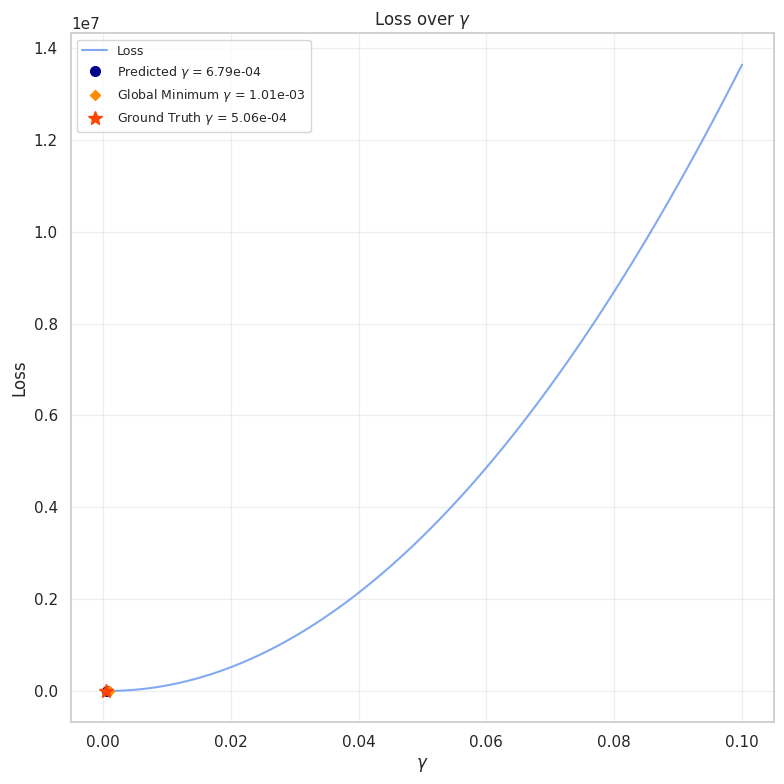

In [55]:
gamma_array, loss_array = zip(*loss_surface)
gamma_array = np.array(gamma_array)
loss_array = np.array(loss_array)

mask = ~np.isnan(loss_array)
gamma_clean = gamma_array[mask]
loss_clean = loss_array[mask]

# Local minima
minima_indices = argrelextrema(loss_clean, np.less)[0]
local_minima_gammas = gamma_clean[minima_indices]
local_minima_losses = loss_clean[minima_indices]

# Global minimum
global_min_idx = np.argmin(loss_clean)

true_gamma = sigma**(2 / k)

# Set plot style
sns.set(style="whitegrid", context="notebook", rc={"axes.grid": True})
plt.rcParams["grid.alpha"] = 0.3

# Use a harmonious color palette
loss_color = "cornflowerblue"
arrow_color = "darkblue"
path_color = "darkblue"
true_gamma_color = "orangered"
global_min_color = "darkorange"

fig, ax = plt.subplots(figsize=(8, 8))

# Plot loss curve
line = sns.lineplot(x=gamma_clean, y=loss_clean, linestyle='-', ax=ax, label='Loss', alpha=0.8, color=loss_color)

# Interpolation for smooth annotation
loss_interp = interp1d(gamma_clean, loss_clean, kind='linear', fill_value='extrapolate')
true_gamma_loss = loss_interp(true_gamma)

# Annotate true gamma
#ax.text(true_gamma + 2e-7, true_gamma_loss, f'{true_gamma_loss:.2f}', fontsize=7, ha='left', va='bottom', color=true_gamma_color)

# Annotate local minima
#for g, l in zip(local_minima_gammas, local_minima_losses):
 #   ax.text(g - 3e-7, l + 12, f'{l:.2f}', fontsize=7, ha='left', va='bottom', color=loss_color)

# Annotate gamma path arrows
#for i in range(len(gamma_path) - 1):
#    x_start, x_end = gamma_path[i], gamma_path[i + 1]
#    y_start, y_end = loss_interp(x_start), loss_interp(x_end)
#    ax.annotate(
#        '', 
#        xy=(x_end, y_end), 
#        xytext=(x_start, y_start),
#        arrowprops=dict(arrowstyle='->', color=arrow_color, alpha=0.8, lw=1),
#        zorder=1
#    )

# Gamma path points
#ax.plot(gamma_path[:-1], loss_interp(gamma_path)[:-1], '.', color=path_color, alpha=0.6, markersize=6)
ax.plot(gamma_path[-1], loss_interp(gamma_path)[-1], 'o', color=path_color, alpha=1, markersize=7, label=f'Predicted $\gamma$ = {gamma_path[-1]:.2e}')
#ax.text(gamma_path[-1] + 2e-7, loss_interp(gamma_path)[-1] - 10, f'{loss_interp(gamma_path)[-1]:.2f}', fontsize=7, ha='left', va='top', color=path_color)

# Global minimum
ax.plot(gamma_clean[global_min_idx], loss_clean[global_min_idx], 'D', markersize=5, color=global_min_color, label=f'Global Minimum $\gamma$ = {gamma_clean[global_min_idx]:.2e}')
ax.plot(true_gamma, true_gamma_loss, '*', color=true_gamma_color, markersize=10, label=f'Ground Truth $\\gamma$ = {true_gamma:.2e}')

# Labels and title
ax.set_xlabel("$\gamma$")
ax.set_ylabel("Loss")
ax.set_title("Loss over $\gamma$")
ax.legend(fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()

### Fixed k

In [15]:
fixed_k_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
initial_sigma = torch.tensor(get_min_distances(samples)).mean()
gamma_vals = torch.linspace(1e-10, 0.05, 100)

loss_surfaces = {}  # Store loss surfaces for each fixed_k

for fixed_k in fixed_k_values:
    print(f"\nScanning for fixed_k = {fixed_k}")
    
    # Initialize model for this fixed_k
    model = Gibbs_Softcore(homogeneous, canonical=True, K=None, fixed_k=fixed_k, initial_sigma=initial_sigma, device=device)
    loss_surface_k = []

    for gamma_val in tqdm(gamma_vals, desc=f"Gamma scan for k={fixed_k}"):
        model.gamma.data = torch.tensor([gamma_val], device=device)

        if not homogeneous:
            model.scale_raw.data = torch.tensor([-2.05130351606], device=device)

        # Compute loss
        points = points.double()
        loss = model.loss(points)
        try:
            loss_surface_k.append((gamma_val.item(), loss.item()))
        except Exception as e:
            loss_surface_k.append((gamma_val.item(), float('nan')))

    loss_surfaces[fixed_k] = loss_surface_k


Scanning for fixed_k = 0.1


Gamma scan for k=0.1: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]



Scanning for fixed_k = 0.2


Gamma scan for k=0.2: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]



Scanning for fixed_k = 0.3


Gamma scan for k=0.3: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]



Scanning for fixed_k = 0.4


Gamma scan for k=0.4: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]



Scanning for fixed_k = 0.5


Gamma scan for k=0.5: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]



Scanning for fixed_k = 0.6


Gamma scan for k=0.6: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]



Scanning for fixed_k = 0.7


Gamma scan for k=0.7: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]



Scanning for fixed_k = 0.8


Gamma scan for k=0.8: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]



Scanning for fixed_k = 0.9


Gamma scan for k=0.9: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]



Scanning for fixed_k = 1.0


Gamma scan for k=1.0: 100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


(0.6, 0.0005050506040404041, -387.0092449440381)


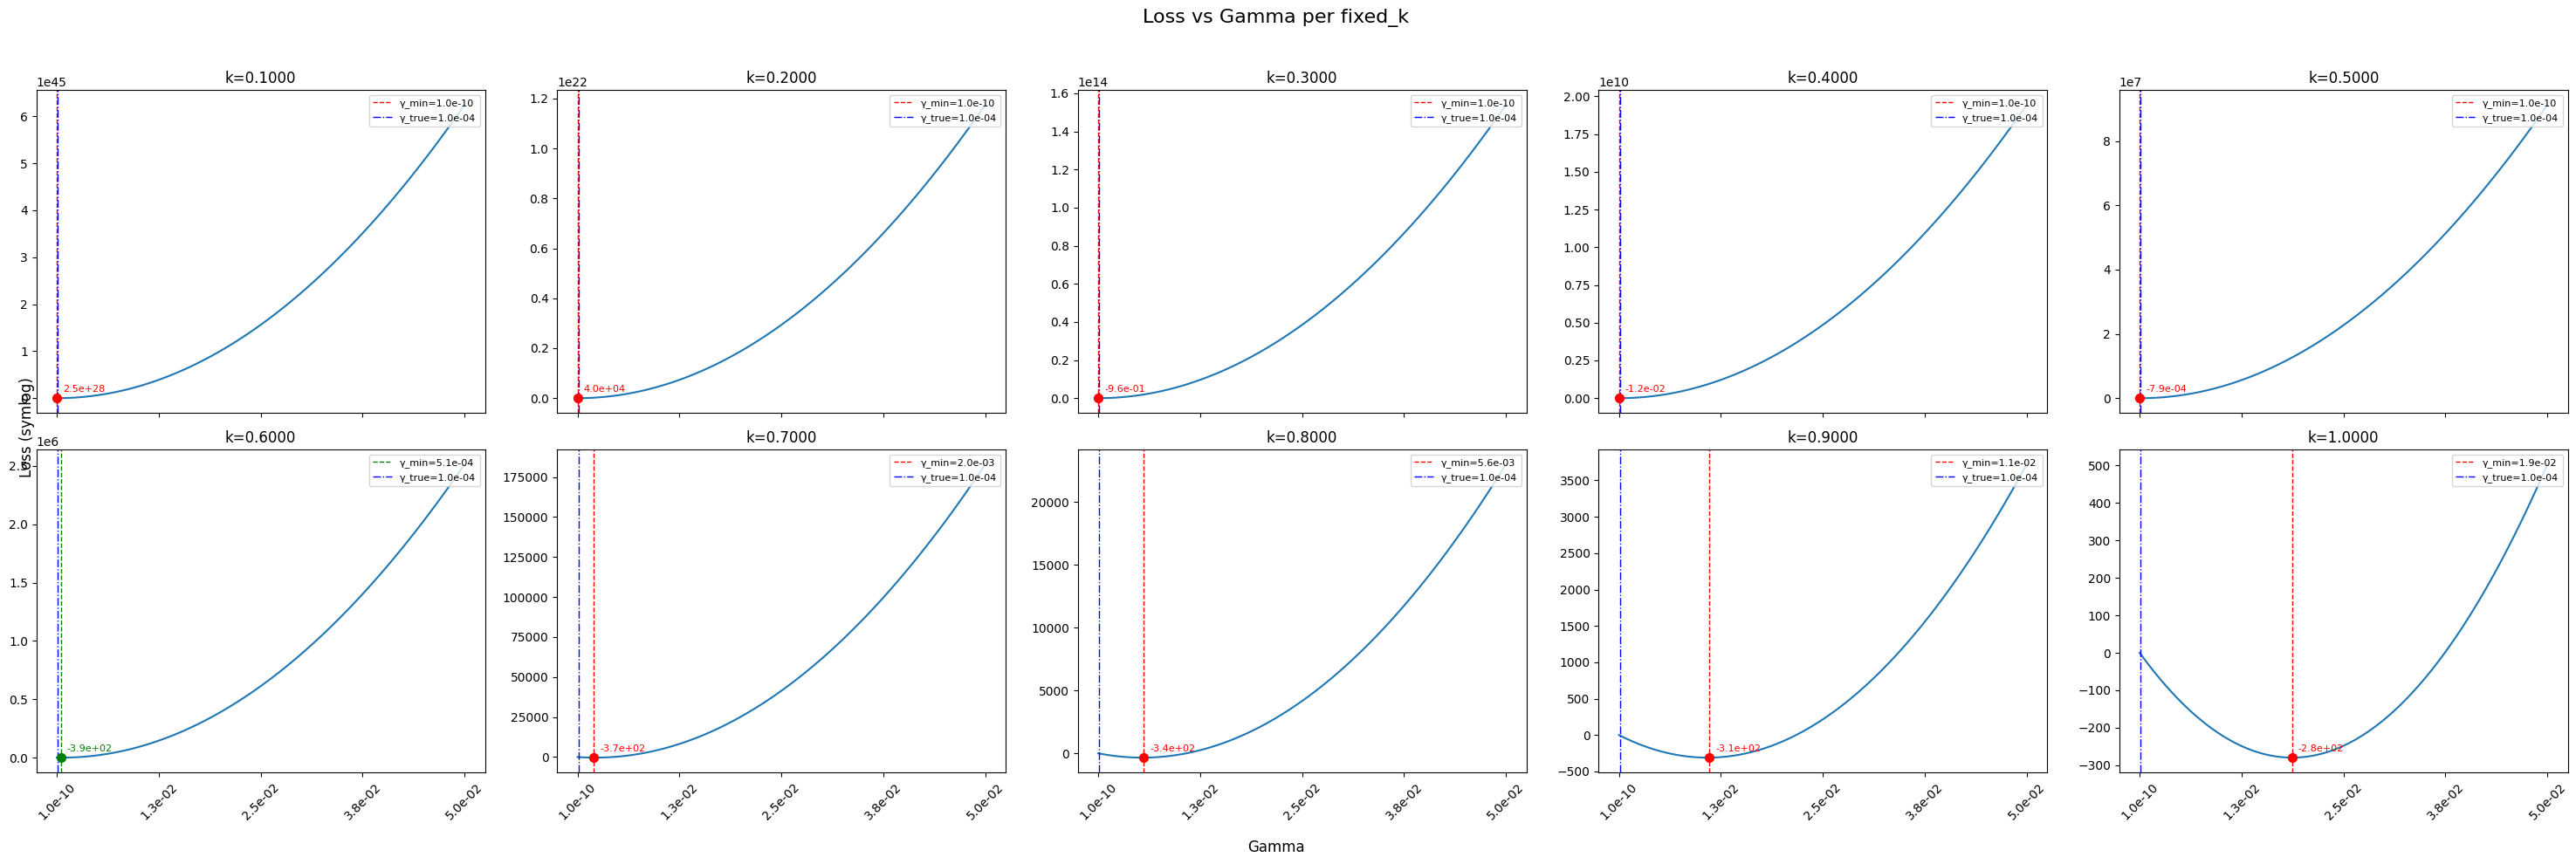

In [20]:
valid_surfaces = {
    k: [(g, l) for g, l in surface if np.isfinite(l)]
    for k, surface in loss_surfaces.items()
}
valid_surfaces = {k: v for k, v in valid_surfaces.items() if v}
sorted_items = sorted(valid_surfaces.items(), key=lambda x: x[0])

n = len(sorted_items)
ncols = 5
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows), sharex=True, sharey=False)
axes = axes.flatten()

minima = []

for ax, (fixed_k, surface) in zip(axes, sorted_items):
    gammas, losses = zip(*surface)
    gammas = np.array(gammas)
    losses = np.array(losses)

    # Find min
    min_idx = np.argmin(losses)
    gamma_min = gammas[min_idx]
    loss_min = losses[min_idx]
    minima.append((fixed_k, gamma_min, loss_min))

global_min = min(minima, key=lambda x: x[2])
print(global_min)


for ax, (fixed_k, surface) in zip(axes, sorted_items):

    gammas, losses = zip(*surface)
    gammas = np.array(gammas)
    losses = np.array(losses)

    # Find min
    min_idx = np.argmin(losses)
    gamma_min = gammas[min_idx]
    loss_min = losses[min_idx]
    minima.append((fixed_k, gamma_min, loss_min))
    is_global_min = (fixed_k, gamma_min, loss_min) == global_min
    color = 'green' if is_global_min else 'red'
    
    # Plot line and min point
    ax.plot(gammas, losses)
    ax.axvline(gamma_min, color=color, linestyle='--', linewidth=1,  label = f"γ_min={gamma_min:.1e}")
    true_gamma = sigma**(2/0.5)
    ax.axvline(true_gamma, color='blue', linestyle='-.', linewidth=1, label=f'γ_true={true_gamma:.1e}')
    ax.scatter(gamma_min, loss_min, color=color, s=50, zorder=5)

    # Optional annotation
    ax.annotate(
        f'{loss_min:.1e}',
        xy=(gamma_min, loss_min),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        color=color
    )

    # Axis formatting
    ax.set_title(f'k={fixed_k:.4f}')
    #ax.set_yscale('symlog', linthresh=1e4)
    #ax.grid(True, which='both', ls='--')
    gamma_ticks = np.linspace(gammas.min(), gammas.max(), 5)
    gamma_ticks = np.unique(np.round(gamma_ticks, decimals=12))  # avoid duplicates

    ax.set_xticks(gamma_ticks)
    ax.set_xticklabels([f'{g:.1e}' for g in gamma_ticks],
                       rotation=45)

    # Add legend with gamma_min
    ax.legend(fontsize=8, loc='upper right')

# Hide extra axes
for i in range(len(sorted_items), len(axes)):
    axes[i].axis('off')

# Layout
fig.supxlabel('Gamma')
fig.supylabel('Loss (symlog)')
fig.suptitle('Loss vs Gamma per fixed_k', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

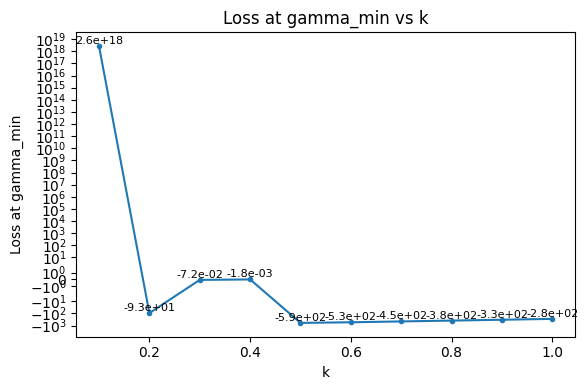

In [21]:
ks, gamma_mins, loss_mins = zip(*minima)

plt.figure(figsize=(6, 4))
plt.plot(ks, loss_mins, marker='.', linestyle='-')
plt.xlabel('k')
plt.ylabel('Loss at gamma_min')
plt.yscale('symlog')
plt.title('Loss at gamma_min vs k')

# Annotate each point with its loss value
for k, loss in zip(ks, loss_mins):
    plt.text(k, loss, f'{loss:.1e}', fontsize=8, ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Lennard Jones Potential

In [21]:
class Gibbs(nn.Module):
    def __init__(self, homogeneous=True, canonical=False, K=None, initial_sigma=0.1, device='cpu'):
        super().__init__()
        torch.manual_seed(123)
        torch.cuda.manual_seed(123)

        self.homogeneous = homogeneous
        self.canonical = canonical
        self.K = K
        self.device = device
        
        if not self.homogeneous:
            self.scale_raw = nn.Parameter(torch.log(torch.rand(1, device=device)))
        
        if self.canonical:
            self.theta1 = nn.Parameter(torch.rand(1, device=device))
            self.theta2 = nn.Parameter(torch.rand(1, device=device))
            self.sigma0 = initial_sigma
        else:  
            self.epsilon_raw = nn.Parameter(torch.log(torch.rand(1, device=device)))
            self.sigma_raw =nn.Parameter(torch.log(torch.rand(1, device=device)))
                
    @property
    def epsilon(self):
        return torch.exp(self.epsilon_raw)

    @property
    def sigma(self):
        return torch.exp(self.sigma_raw)

    @property
    def scale(self):
        return torch.exp(self.scale_raw)

    def forward(self, x, mask):
        _, N, _ = x.shape
        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=self.device)

        xi, xj = x[:, i_idx, :], x[:, j_idx, :]
        diff = xi - xj
        r2 = (diff ** 2).sum(dim=-1).clamp(min=1e-10)
        r = torch.sqrt(r2)

        mask_i, mask_j = mask[:, i_idx], mask[:, j_idx]
        pairwise_mask = mask_i & mask_j
        
        phi = torch.zeros_like(r)
        if self.canonical:
            sigma0_r = (self.sigma0 / r[pairwise_mask])**6
            phi[pairwise_mask] =  self.theta1 * sigma0_r**2 - self.theta2 * sigma0_r
        else:
            sigma_r = (self.sigma / r[pairwise_mask])**6
            phi[pairwise_mask] = 4 * self.epsilon * (sigma_r**2 - sigma_r)

        energy = phi.sum(dim=-1)
        if self.homogeneous:
            return -energy
        return -x.pow(2).sum(dim=-1).sum(dim=-1) / self.scale**2 - energy

    def compute_psi(self, x, mask):
        output = self.forward(x, mask)
        grad_outputs = torch.ones_like(output)
        return torch.autograd.grad(
            output, x, grad_outputs=grad_outputs,
            retain_graph=True, create_graph=True,
        )[0]
        
    def loss(self, points, threshold=1e-2, collect_debug=False):
        lengths = points[:, 0, -1].to(dtype=torch.int64, device=self.device)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]
        mask = torch.arange(max_length, device=device).unsqueeze(0) < lengths.unsqueeze(1)

        psi_x = self.compute_psi(x_t, mask)
        norm_squared = psi_x.pow(2).sum(dim=-1) * mask

        if self.K:
            divergence = 0
            for _ in range(self.K):
                epsilon = torch.randint(0, 2, x_t.shape, device=self.device).float() * 2 - 1
                eps_psi = (psi_x * epsilon).sum()
                divergence_est = torch.autograd.grad(
                    eps_psi, x_t, create_graph=True
                )[0]
                divergence += (divergence_est * epsilon).sum(dim=-1) 
            divergence = (divergence / self.K) * mask
        else:
            divergence = torch.zeros(x_t.shape[0], x_t.shape[1], device=self.device)
            for d in range(x_t.shape[-1]):
                for i in range(x_t.shape[-2]):
                    second_grad = torch.autograd.grad(
                        psi_x[:, i, d].sum(), x_t, retain_graph=True, create_graph=True
                    )[0][:, i, d]
                    divergence[:, i] += second_grad
            divergence = divergence * mask

        total_loss = (0.5 * norm_squared + divergence).sum(dim=-1) / lengths
        return total_loss.mean()

### Original Parameters

In [24]:
K_widget = widgets.FloatText(
    value=None,
    description='K',
    layout=widgets.Layout(width='200px')
)

xmin_widget = widgets.FloatText(
    value=3.5184280005839307e-07,
    description='xmin',
    layout=widgets.Layout(width='200px')
)

xmax_widget = widgets.FloatText(
    value=0.6,
    description='xmax',
    layout=widgets.Layout(width='200px')
)

# Y range widgets
ymin_widget = widgets.FloatText(
    value=0.01,
    description='ymin',
    layout=widgets.Layout(width='200px')
)

ymax_widget = widgets.FloatText(
    value= 0.3,
    description='ymax',
    layout=widgets.Layout(width='200px')
)

range_box_x = widgets.HBox([xmin_widget, xmax_widget])
range_box_y = widgets.HBox([ymin_widget, ymax_widget])

ui = widgets.VBox([
    K_widget,
    widgets.Label("X range:"),
    range_box_x,
    widgets.Label("Y range:"),
    range_box_y
])

display(ui)

In [25]:
canonical = False
K = K_widget.value if K_widget.value != 0 else None
initial_sigma = torch.tensor(get_min_distances(samples)).mean()
model = Gibbs(homogeneous, canonical, K=K, device=device)

# Grid setup
xmin, xmax = xmin_widget.value, xmax_widget.value
ymin, ymax = ymin_widget.value, ymax_widget.value
sigma_vals = torch.linspace(ymin, ymax, 25)
log_sigma_vals = torch.log(sigma_vals)
epsilon_vals = torch.linspace(xmin, xmax, 25)
log_epsilon_vals = torch.log(epsilon_vals)  

loss_surface = []

# Grid scan with progress bar
for i, log_epsilon in tqdm(enumerate(log_epsilon_vals), total=len(log_epsilon_vals), desc="Scanning epsilon and sigma values"):
    for j, log_sigma in enumerate(log_sigma_vals):
        sigma_raw = log_sigma
        epsilon_raw = log_epsilon
        
        model.epsilon_raw.data = torch.tensor([epsilon_raw], device=device)
        model.sigma_raw.data = torch.tensor([sigma_raw], device=device)
        if not homogeneous:
            model.scale_raw.data = torch.tensor([-2.05130351606], device=device)
        
        # Compute loss
        points = points.double()
        loss = model.loss(points)
        try:
            loss_surface.append((sigma_vals[j].item(), epsilon_vals[i].item(), loss.item()))
        except Exception as e:
            loss_surface.append((sigma_vals[j].item(), epsilon_vals[i].item(), float('nan')))

Scanning epsilon and sigma values: 100%|██████████| 25/25 [01:58<00:00,  4.73s/it]


/tmp/ipykernel_838459/2202467399.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


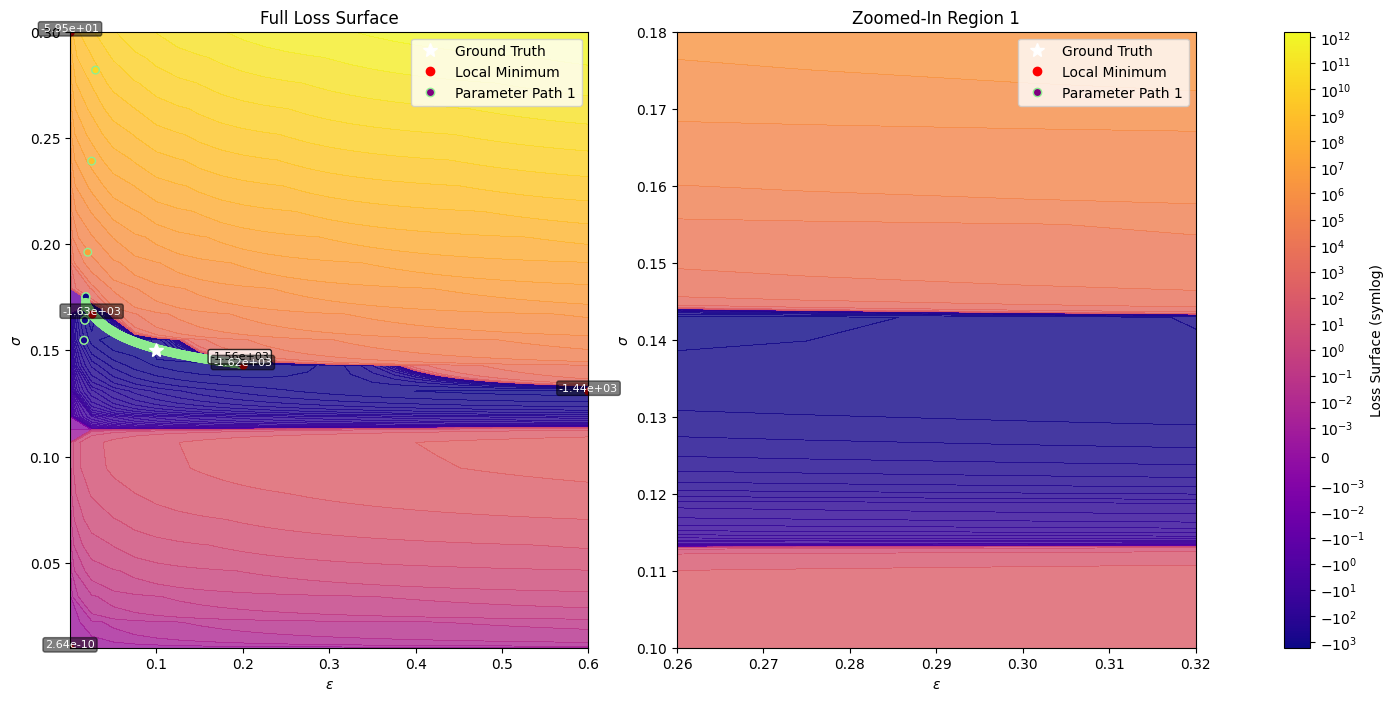

In [29]:
df = pd.DataFrame(loss_surface, columns=["sigma", "epsilon", "loss"])
pivot = df.pivot(index="sigma", columns="epsilon", values="loss")

sigma_vals_np = pivot.index.values
epsilon_vals_np = pivot.columns.values
loss_surface_np = pivot.values
loss_surface_np[np.isinf(loss_surface_np)] = np.nan

E, S = np.meshgrid(epsilon_vals_np, sigma_vals_np)
masked_loss = np.ma.masked_invalid(loss_surface_np)

# Replace masked array with plain array
Z = loss_surface_np  # just use NaN-containing array

# Create color-normalization and level setup
linthresh = 1e-3
vmin = np.nanmin(Z)
vmax = np.nanpercentile(Z, 100)

neg_levels = -np.geomspace(linthresh, -vmin, num=50)
pos_levels = np.geomspace(linthresh, vmax, num=30)
symlog_levels = np.concatenate((neg_levels[::-1], [0], pos_levels))

# Colormaps and norm
cmap_contour = plt.cm.plasma.copy()
#cmap_contour.set_bad(color='gray')  # Handle NaNs in the colormap

norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)

path = f"simulation_results/*epsilon*sigma{sigma:.2f}_hom_results_original_epoch1000.json"
num_paths = len(glob.glob(path))

# Define a list of marker styles
markers = ['o', '^', 's', 'D', 'v', 'P', '*', 'X']  # Extend as needed
edge_color = 'lightgreen'

base = generate_binary_structure(2, 2) 
neighborhood = iterate_structure(base, 4)
local_min = (Z == minimum_filter(Z, footprint=neighborhood, mode='mirror'))
local_min[np.isnan(Z)] = False
local_min_coords = np.argwhere(local_min)

# Define two zoom regions
zoom1_xmin, zoom1_xmax = 0.26, 0.32
zoom1_ymin, zoom1_ymax = 0.1, 0.18

zoom2_xmin, zoom2_xmax = 0.15, 0.2
zoom2_ymin, zoom2_ymax = 0.1, 0.18

# Setup figure with three subplots side by side
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.25)

# Axes
ax = fig.add_subplot(gs[0])    # Full
ax2 = fig.add_subplot(gs[1])   # Zoom 1
#ax3 = fig.add_subplot(gs[2])   # Zoom 2
cax = fig.add_subplot(gs[2])   # Colorbar

# Plot on all three axes
for axis, xlim, ylim, title in [
    (ax, (epsilon_vals_np[0], epsilon_vals_np[-1]), (sigma_vals_np[0], sigma_vals_np[-1]), "Full Loss Surface"),
    (ax2, (zoom1_xmin, zoom1_xmax), (zoom1_ymin, zoom1_ymax), "Zoomed-In Region 1"),
    #(ax3, (zoom2_xmin, zoom2_xmax), (zoom2_ymin, zoom2_ymax), "Zoomed-In Region 2"),
]:
    cs = axis.contourf(E, S, masked_loss, levels=symlog_levels, cmap=cmap_contour, norm=norm, alpha=0.8)
    axis.set_xlim(*xlim)
    axis.set_ylim(*ylim)
    axis.set_title(title)
    axis.set_xlabel("$\epsilon$")
    axis.set_ylabel("$\sigma$")

    if axis == ax:
        legend_elements = [
            Line2D([0], [0], marker='*', color='white', label='Ground Truth', linestyle='', markersize=10),
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]
    #elif axis == ax3:
    #    legend_elements = [
    #        Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
    #    ]
    else:
        legend_elements = [
            Line2D([0], [0], marker='*', color='white', label='Ground Truth', linestyle='', markersize=10),
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]


    for idx, filename in enumerate(glob.glob(path), start=1):
        with open(filename, 'r') as f:
            data = json.load(f)
        path_epsilons = parse_and_exp(data["param_history"]['epsilon_raw'])
        path_sigmas = parse_and_exp(data["param_history"]['sigma_raw'])
        # path_epsilons = np.full_like(path_sigmas, 0.1)
        losses = data['avg_epoch_losses']
        # Add training paths and local minima
        def clip_to_bounds(x, y, xlim, ylim):
            x_clipped = min(max(x, xlim[0]), xlim[1])
            y_clipped = min(max(y, ylim[0]), ylim[1])
            return x_clipped, y_clipped

        # Choose marker shape by index and set fixed edge color
        marker_style = markers[(idx - 1) % len(markers)]
        sc = axis.scatter(path_epsilons, path_sigmas, c=losses, cmap=cmap_contour, norm=norm,
                  edgecolor=edge_color, marker=marker_style, s=30)
        
        if axis == ax2 and idx==1:
            legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
                   markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        #elif axis == ax3 and idx==2:
        #    legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
        #           markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        elif axis == ax:
            legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
                   markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        #for i in range(1, len(path_epsilons)):
        #    x0, y0 = path_epsilons[i - 1], path_sigmas[i - 1]
        #    x1, y1 = path_epsilons[i], path_sigmas[i]
        
            # Only draw if at least part of the arrow is in bounds
        #    if ((xlim[0] <= x0 <= xlim[1] or xlim[0] <= x1 <= xlim[1]) and
        #        (ylim[0] <= y0 <= ylim[1] or ylim[0] <= y1 <= ylim[1])):
                
                # Clip start point to boundary if it's outside
        #        if not (xlim[0] <= x0 <= xlim[1] and ylim[0] <= y0 <= ylim[1]):
        #            x0, y0 = clip_to_bounds(x0, y0, xlim, ylim)
        #        if not (xlim[0] <= x1 <= xlim[1] and ylim[0] <= y1 <= ylim[1]):
        #            x1, y1 = clip_to_bounds(x1, y1, xlim, ylim)
        
        #        axis.annotate("",
        #            xy=(x1, y1), xytext=(x0, y0),
        #            arrowprops=dict(arrowstyle="->", color=edge_color, lw=1),
        #            size=6, zorder=1)
        if xlim[0] < path_epsilons[-1] < xlim[1] and ylim[0] < path_sigmas[-1] < ylim[1]:
            axis.text(path_epsilons[-1], path_sigmas[-1] + 0.001, f"{losses[-1]:.2e}", color='black', fontsize=8,
                      ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))
    
    axis.legend(handles=legend_elements, loc='upper right', framealpha=0.8)
    
    # Add local minima
    for i, j in local_min_coords:
        x = epsilon_vals_np[j]
        y = sigma_vals_np[i]
        loss_val = Z[i, j]
        if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
            axis.plot(x, y, marker='o', color='red', markersize=5)
            axis.text(x, y - 0.001, f"{loss_val:.2e}", color='white', fontsize=8,
                      ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

    # Ground truth
    axis.plot(epsilon, sigma, marker='*', color='white', markersize=10)

# Colorbar
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label("Loss Surface (symlog)")

fig.tight_layout()
plt.show()


/tmp/ipykernel_689566/3931667866.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


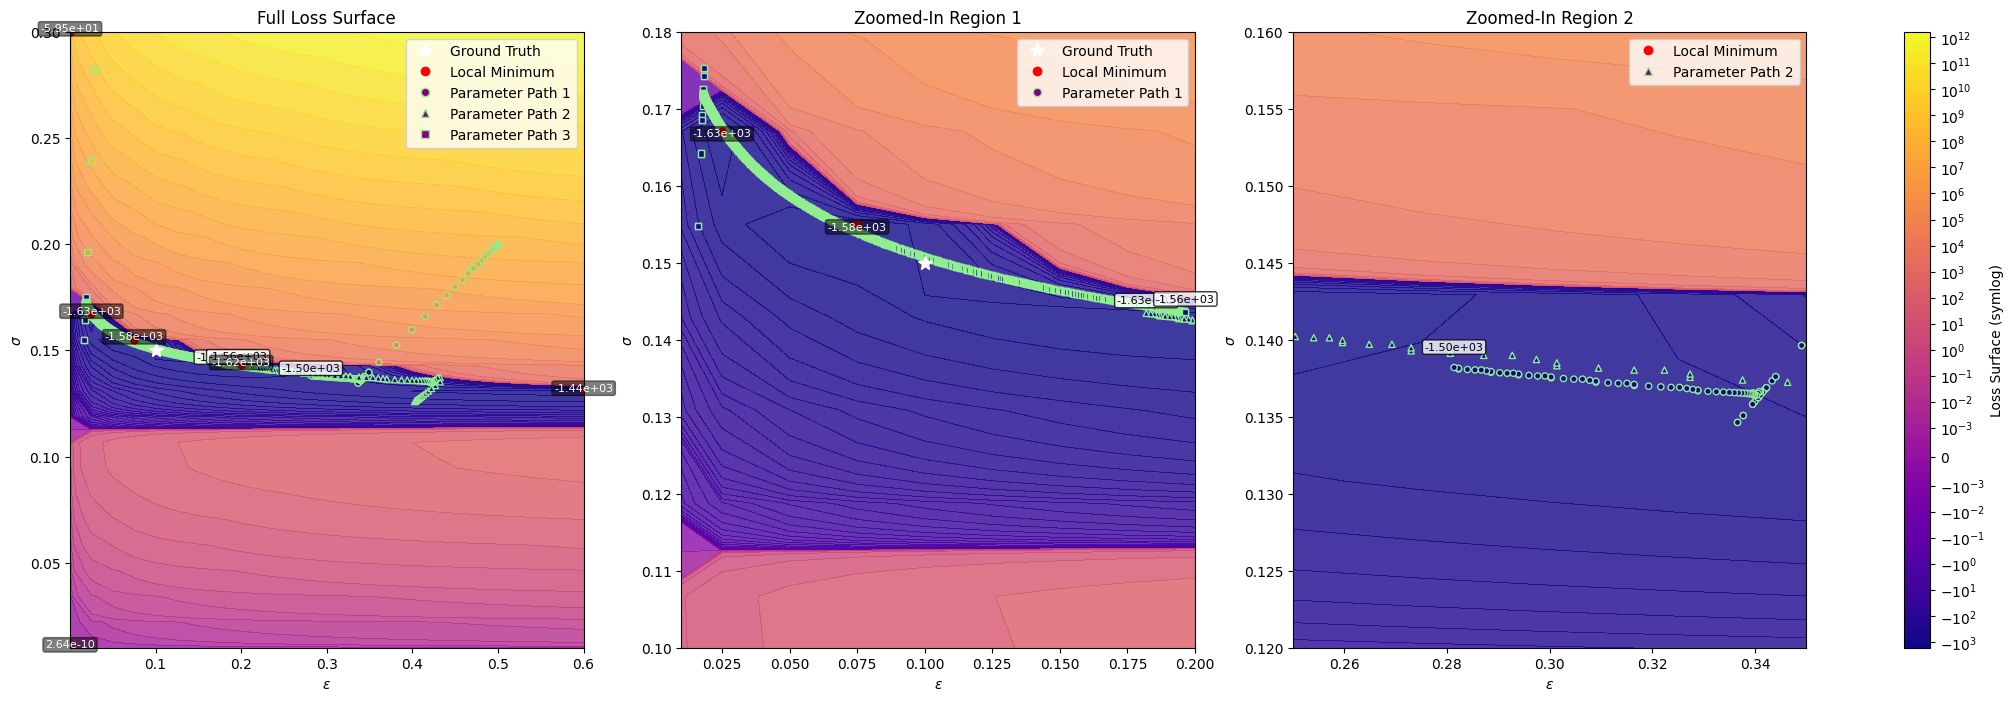

In [17]:
df = pd.DataFrame(loss_surface, columns=["sigma", "epsilon", "loss"])
pivot = df.pivot(index="sigma", columns="epsilon", values="loss")

sigma_vals_np = pivot.index.values
epsilon_vals_np = pivot.columns.values
loss_surface_np = pivot.values
loss_surface_np[np.isinf(loss_surface_np)] = np.nan

E, S = np.meshgrid(epsilon_vals_np, sigma_vals_np)
masked_loss = np.ma.masked_invalid(loss_surface_np)

# Replace masked array with plain array
Z = loss_surface_np  # just use NaN-containing array

# Create color-normalization and level setup
linthresh = 1e-3
vmin = np.nanmin(Z)
vmax = np.nanpercentile(Z, 100)

neg_levels = -np.geomspace(linthresh, -vmin, num=50)
pos_levels = np.geomspace(linthresh, vmax, num=30)
symlog_levels = np.concatenate((neg_levels[::-1], [0], pos_levels))

# Colormaps and norm
cmap_contour = plt.cm.plasma.copy()
#cmap_contour.set_bad(color='gray')  # Handle NaNs in the colormap

norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)

path_pattern = f"simulation_results/*epsilon*sigma{sigma:.2f}_hom_results_original_*.json"

# Filter out files containing 'hte'
filtered_files = [file for file in glob.glob(path_pattern) if 'hte' not in file]

num_paths = len(glob.glob(path))

# Define a list of marker styles
markers = ['o', '^', 's', 'D', 'v', 'P', '*', 'X']  # Extend as needed
edge_color = 'lightgreen'

base = generate_binary_structure(2, 2) 
neighborhood = iterate_structure(base, 1)
local_min = (Z == minimum_filter(Z, footprint=neighborhood, mode='mirror'))
local_min[np.isnan(Z)] = False
local_min_coords = np.argwhere(local_min)

# Define two zoom regions
zoom1_xmin, zoom1_xmax = 0.01, 0.2
zoom1_ymin, zoom1_ymax = 0.1, 0.18

zoom2_xmin, zoom2_xmax = 0.25, 0.35
zoom2_ymin, zoom2_ymax = 0.12, 0.16

# Setup figure with three subplots side by side
fig = plt.figure(figsize=(24, 8))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.25)

# Axes
ax = fig.add_subplot(gs[0])    # Full
ax2 = fig.add_subplot(gs[1])   # Zoom 1
ax3 = fig.add_subplot(gs[2])   # Zoom 2
cax = fig.add_subplot(gs[3])   # Colorbar

# Plot on all three axes
for axis, xlim, ylim, title in [
    (ax, (epsilon_vals_np[0], epsilon_vals_np[-1]), (sigma_vals_np[0], sigma_vals_np[-1]), "Full Loss Surface"),
    (ax2, (zoom1_xmin, zoom1_xmax), (zoom1_ymin, zoom1_ymax), "Zoomed-In Region 1"),
    (ax3, (zoom2_xmin, zoom2_xmax), (zoom2_ymin, zoom2_ymax), "Zoomed-In Region 2"),
]:
    cs = axis.contourf(E, S, masked_loss, levels=symlog_levels, cmap=cmap_contour, norm=norm, alpha=0.8)
    axis.set_xlim(*xlim)
    axis.set_ylim(*ylim)
    axis.set_title(title)
    axis.set_xlabel("$\epsilon$")
    axis.set_ylabel("$\sigma$")

    if axis == ax:
        legend_elements = [
            Line2D([0], [0], marker='*', color='white', label='Ground Truth', linestyle='', markersize=10),
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]
    elif axis == ax3:
        legend_elements = [
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]
    else:
        legend_elements = [
            Line2D([0], [0], marker='*', color='white', label='Ground Truth', linestyle='', markersize=10),
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]


    for idx, filename in enumerate(filtered_files, start=1):
        with open(filename, 'r') as f:
            data = json.load(f)
        path_epsilons = parse_and_exp(data["param_history"]['epsilon_raw'])
        path_sigmas = parse_and_exp(data["param_history"]['sigma_raw'])
        losses = data['avg_epoch_losses']
        # Add training paths and local minima
        def clip_to_bounds(x, y, xlim, ylim):
            x_clipped = min(max(x, xlim[0]), xlim[1])
            y_clipped = min(max(y, ylim[0]), ylim[1])
            return x_clipped, y_clipped

        # Choose marker shape by index and set fixed edge color
        marker_style = markers[(idx - 1) % len(markers)]
        sc = axis.scatter(path_epsilons, path_sigmas, c=losses, cmap=cmap_contour, norm=norm,
                  edgecolor=edge_color, marker=marker_style, s=20)
        
        if axis == ax2 and idx==1:
            legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
                   markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        elif axis == ax3 and idx==2:
            legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
                   markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        elif axis == ax:
            legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
                   markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        #for i in range(1, len(path_epsilons)):
        #    x0, y0 = path_epsilons[i - 1], path_sigmas[i - 1]
        #    x1, y1 = path_epsilons[i], path_sigmas[i]
        
            # Only draw if at least part of the arrow is in bounds
        #    if ((xlim[0] <= x0 <= xlim[1] or xlim[0] <= x1 <= xlim[1]) and
        #        (ylim[0] <= y0 <= ylim[1] or ylim[0] <= y1 <= ylim[1])):
                
                # Clip start point to boundary if it's outside
        #        if not (xlim[0] <= x0 <= xlim[1] and ylim[0] <= y0 <= ylim[1]):
        #            x0, y0 = clip_to_bounds(x0, y0, xlim, ylim)
        #        if not (xlim[0] <= x1 <= xlim[1] and ylim[0] <= y1 <= ylim[1]):
        #            x1, y1 = clip_to_bounds(x1, y1, xlim, ylim)
        
        #        axis.annotate("",
        #            xy=(x1, y1), xytext=(x0, y0),
        #            arrowprops=dict(arrowstyle="->", color=edge_color, lw=1),
        #            size=6, zorder=1)
        if xlim[0] < path_epsilons[-1] < xlim[1] and ylim[0] < path_sigmas[-1] < ylim[1]:
            axis.text(path_epsilons[-1], path_sigmas[-1] + 0.001, f"{losses[-1]:.2e}", color='black', fontsize=8,
                      ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))
    
    axis.legend(handles=legend_elements, loc='upper right', framealpha=0.8)
    
    # Add local minima
    for i, j in local_min_coords:
        x = epsilon_vals_np[j]
        y = sigma_vals_np[i]
        loss_val = Z[i, j]
        if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
            axis.plot(x, y, marker='o', color='red', markersize=5)
            axis.text(x, y - 0.001, f"{loss_val:.2e}", color='white', fontsize=8,
                      ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

    # Ground truth
    axis.plot(epsilon, sigma, marker='*', color='white', markersize=10)

# Colorbar
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label("Loss Surface (symlog)")

fig.tight_layout()
plt.show()


### Canonical Parameters

In [24]:
canonical = True
K = 200
initial_sigma = torch.tensor(get_min_distances(samples)).mean()
model = Gibbs(homogeneous, canonical, K=K, initial_sigma=initial_sigma, device=device)
model.eval()

# Grid setup
ymin, ymax = 0, 5
xmin, xmax = 0, 5
theta1_vals = torch.linspace(xmin, xmax, 25)
theta2_vals = torch.linspace(ymin, ymax, 25)

loss_surface = []

# Grid scan with progress bar
for i, theta1 in tqdm(enumerate(theta1_vals), total=len(theta1_vals), desc="Scanning theta1 and theta2 values"):
    for j, theta2 in enumerate(theta2_vals):
        
        # Set model parameters (no grad tracking needed)
        with torch.no_grad():
            model.theta1.copy_(torch.tensor([theta1], device=device))
            model.theta2.copy_(torch.tensor([theta2], device=device))
            if not homogeneous:
                model.scale_raw.copy_(torch.tensor([-2.05130351606]))
        
        # Compute loss
        points = points.double()
        loss = model.loss(points)
        try:
            loss_surface.append((theta1_vals[i].item(), theta2_vals[j].item(), loss.item()))
        except Exception as e:
            loss_surface.append((theta1_vals[i].item(), theta2_vals[j].item(), float('nan')))

Scanning theta1 and theta2 values: 100%|██████████| 25/25 [02:11<00:00,  5.24s/it]


/tmp/ipykernel_2672973/2719217307.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


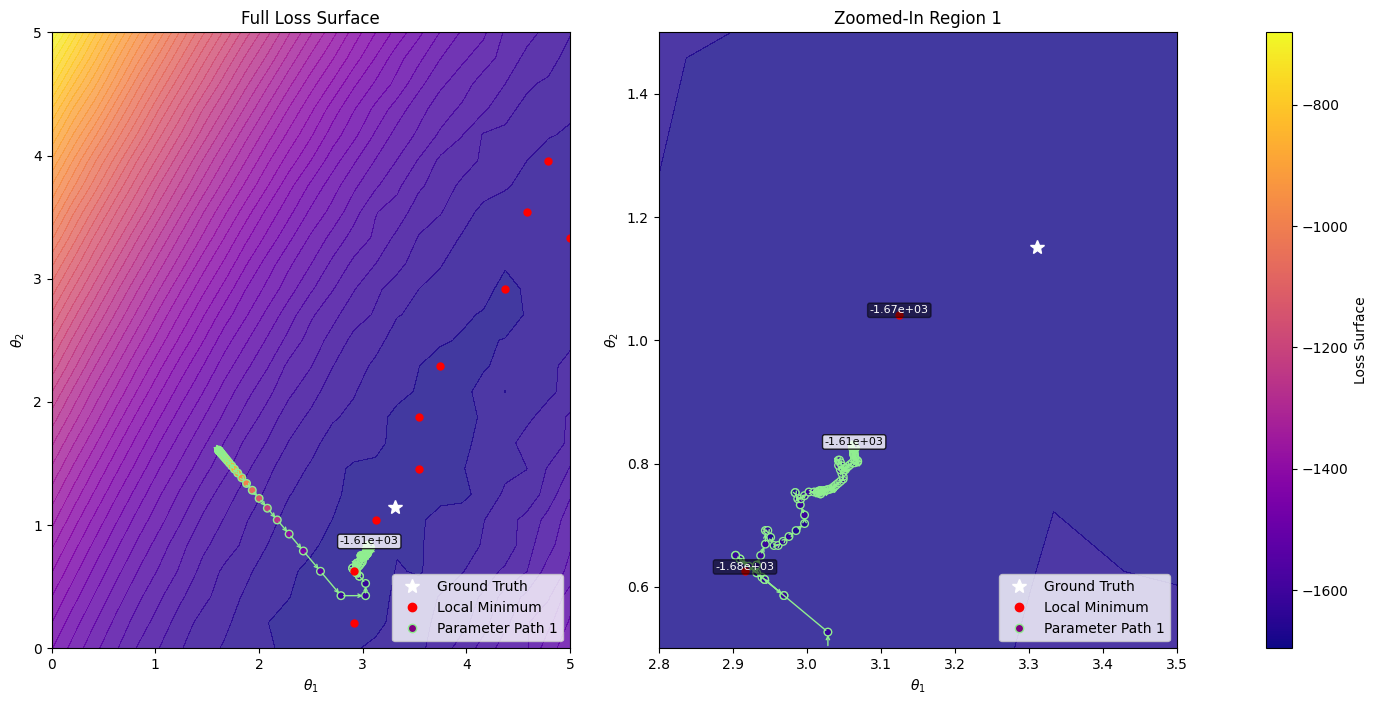

In [25]:
# Create DataFrame and pivot
df = pd.DataFrame(loss_surface, columns=["theta1", "theta2", "loss"])
pivot = df.pivot(index="theta2", columns="theta1", values="loss")

# Extract grid and values
theta2_vals_np = pivot.index.values
theta1_vals_np = pivot.columns.values
loss_surface_np = pivot.values
loss_surface_np[np.isinf(loss_surface_np)] = np.nan


# Create meshgrid
T1, T2 = np.meshgrid(theta1_vals_np, theta2_vals_np)  # correct order
masked_loss = np.ma.masked_invalid(loss_surface_np)

# Replace masked array with plain array
Z = loss_surface_np

linthresh = 1e-3
vmin = np.nanmin(Z)
vmax = np.nanpercentile(Z, 100)

norm = None
symlog_levels = np.linspace(vmin, vmax, 50)

cmap_contour = plt.cm.plasma.copy()

path = f"simulation_results/*epsilon*sigma{sigma:.2f}_hom_results_canonical_initial_sigma_k200.json"
num_paths = len(glob.glob(path))
markers = ['o', '^', 's', 'D', 'v', 'P', '*', 'X']  # Extend as needed
edge_color = 'lightgreen'

base = generate_binary_structure(2, 2) 
neighborhood = iterate_structure(base, 1)
local_min = (Z == minimum_filter(Z, footprint=neighborhood, mode='mirror'))
local_min[np.isnan(Z)] = False
local_min_coords = np.argwhere(local_min)

# Define two zoom regions
zoom1_xmin, zoom1_xmax = 2.8, 3.5
zoom1_ymin, zoom1_ymax = 0.5, 1.5

zoom2_xmin, zoom2_xmax = 56.5, 58.5
zoom2_ymin, zoom2_ymax = 8, 10

# Setup figure with three subplots side by side
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.25)

# Axes
ax = fig.add_subplot(gs[0])    # Full
ax2 = fig.add_subplot(gs[1])   # Zoom 1
#ax3 = fig.add_subplot(gs[2])   # Zoom 2
cax = fig.add_subplot(gs[2])   # Colorbar

# Plot on all three axes
for axis, xlim, ylim, title in [
    (ax, (theta1_vals_np[0], theta1_vals_np[-1]), (theta2_vals_np[0], theta2_vals_np[-1]), "Full Loss Surface"),
    (ax2, (zoom1_xmin, zoom1_xmax), (zoom1_ymin, zoom1_ymax), "Zoomed-In Region 1"),
    #(ax3, (zoom2_xmin, zoom2_xmax), (zoom2_ymin, zoom2_ymax), "Zoomed-In Region 2"),
]:
    cs = axis.contourf(T1, T2, masked_loss, levels=symlog_levels, cmap=cmap_contour, norm=norm, alpha=0.8)
    axis.set_xlim(*xlim)
    axis.set_ylim(*ylim)
    axis.set_title(title)
    axis.set_xlabel("$\\theta_1$")
    axis.set_ylabel("$\\theta_2$")

    if axis == ax:
        legend_elements = [
            Line2D([0], [0], marker='*', color='white', label='Ground Truth', linestyle='', markersize=10),
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]
    elif axis == ax2: # or axis == ax2:
        legend_elements = [
            Line2D([0], [0], marker='*', color='white', label='Ground Truth', linestyle='', markersize=10),
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]
    else:
        legend_elements = [
            Line2D([0], [0], marker='*', color='white', label='Ground Truth', linestyle='', markersize=10),
            Line2D([0], [0], marker='o', color='red', label='Local Minimum', linestyle='', markersize=6),
        ]


    # Add training paths
    for idx, filename in enumerate(glob.glob(path), start=1):
        with open(filename, 'r') as f:
            data = json.load(f)
        path_theta1s = parse(data["param_history"]['theta1'])
        path_theta2s = parse(data["param_history"]['theta2'])
        losses = data['avg_epoch_losses']
        
        # Choose marker shape by index and set fixed edge color
        marker_style = markers[(idx - 1) % len(markers)]
        sc = axis.scatter(path_theta1s, path_theta2s, c=losses, cmap=cmap_contour, norm=norm,
                     edgecolor=edge_color, s=30)
        
        if axis == ax2 and idx==1:
            legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
                   markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        #elif axis == ax3 and idx==1:
          #  legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
          #         markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))
        elif axis == ax:
            legend_elements.append(Line2D([0], [0], marker=marker_style, markerfacecolor='purple',
                   markeredgecolor=edge_color, linestyle='', label=f'Parameter Path {idx}', markersize=6))

        for i in range(1, len(path_theta1s)):
            x0, y0 = path_theta1s[i - 1], path_theta2s[i - 1]
            x1, y1 = path_theta1s[i], path_theta2s[i]
       
            # Only draw if at least part of the arrow is in bounds
            if ((xlim[0] <= x0 <= xlim[1] or xlim[0] <= x1 <= xlim[1]) and
                (ylim[0] <= y0 <= ylim[1] or ylim[0] <= y1 <= ylim[1])):
                
                # Clip start point to boundary if it's outside
                if not (xlim[0] <= x0 <= xlim[1] and ylim[0] <= y0 <= ylim[1]):
                    x0, y0 = clip_to_bounds(x0, y0, xlim, ylim)
                if not (xlim[0] <= x1 <= xlim[1] and ylim[0] <= y1 <= ylim[1]):
                    x1, y1 = clip_to_bounds(x1, y1, xlim, ylim)
        
                axis.annotate("",
                    xy=(x1, y1), xytext=(x0, y0),
                    arrowprops=dict(arrowstyle="->", color=edge_color, lw=1),
                    size=6, zorder=1)
        if xlim[0] < path_theta1s[-1] < xlim[1] and ylim[0] < path_theta2s[-1] < ylim[1]:
            axis.text(path_theta1s[-1], path_theta2s[-1] + 0.001, f"{losses[-1]:.2e}", color='black', fontsize=8,
                      ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))
    axis.legend(handles=legend_elements, loc='lower right', framealpha=0.8)

    # Add local minima
    for i, j in local_min_coords:
        x = theta1_vals_np[j]
        y = theta2_vals_np[i]
        loss_val = Z[i, j]
        if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
            axis.plot(x, y, marker='o', color='red', markersize=5)
            if axis != ax:
                axis.text(x, y - 0.001, f"{loss_val:.2e}", color='white', fontsize=8,
                          ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

    # Ground truth
    axis.plot(4*epsilon*(sigma/initial_sigma)**12, 4*epsilon*(sigma/initial_sigma)**6, marker='*', color='white', markersize=10)

# Colorbar
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label("Loss Surface")

fig.tight_layout()
plt.show()

## Hardcore process

In [74]:
def parse_filename(filename):
    basename = os.path.basename(filename)
    homogeneous = "hom" in basename
    process = "sftcr" if "sftcr" in basename else "lj"
    if process == "sftcr":
        sigma = float(re.search(r"sigma([0-9.]+)", basename).group(1))
        kappa = float(re.search(r"kappa([0-9.]+)", basename).group(1))
        return torch.tensor(kappa), sigma, homogeneous, process
    else:
        sigma = float(re.search(r"sigma([0-9.]+)", basename).group(1))
        epsilon = float(re.search(r"epsilon([0-9.]+)", basename).group(1))
        return torch.tensor(epsilon), sigma, homogeneous, process

def get_min_distances(filename):
    df = pd.read_csv(filename)
    _, sigma, _, _ = parse_filename(filename)
    samples = [torch.tensor(group[["x", "y"]].values, dtype=torch.float32, device=device)
               for _, group in df.groupby("sim")][:10]

    min_dists = []
    for points in samples:
        if len(points) < 2:
            continue
        dist_matrix = torch.cdist(points, points)
        min_dist = torch.min(dist_matrix + torch.eye(len(points), device=device) * 1e6)  # exclude self
        # Adjust with n/(n+1)
        min_dists.append(min_dist.item() * len(points) / (len(points) + 1))

    return sigma, min_dists

def check_collapse(mean_min_dist, sigma, threshold=0.85):
    """Return True if we expect collapse to hard core, based on distance ratio."""
    rho = mean_min_dist / sigma
    return rho >= threshold

# Filenames
filenames = [
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.01_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.025_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.05_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.075_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.1_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.125_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.15_hom.csv",
]

# Results
sigmas = []
mean_min_dists = []
collapse_flags = []

for file in filenames:
    sigma, min_dists = get_min_distances(file)
    print(sigma, min_dists)
    mean_min_dist = torch.tensor(min_dists).mean().item()
    sigmas.append(sigma)
    mean_min_dists.append(mean_min_dist)
    collapse_flags.append(check_collapse(mean_min_dist, sigma))

# Output
for sigma, dist, collapse in zip(sigmas, mean_min_dists, collapse_flags):
    status = "COLLAPSES" if collapse else "SOFTCORE"
    print(f"Sigma={sigma:.4f}, Mean Min Dist={dist:.6f}, Ratio={dist/sigma:.3f} → {status}")

0.01 [0.01011219762793963, 0.01052992886744498, 0.009095609685410781, 0.009140167580893033, 0.013413359708976677, 0.006728220110955207, 0.009612227124069152, 0.010763684048114485, 0.0087939403031575, 0.00968544668531124]
0.025 [0.019561648814250595, 0.024917723116327506, 0.023919045243222834, 0.022083331573577156, 0.022836401405285544, 0.021002775203291472, 0.029321554576671575, 0.021031697720008076, 0.018471409146203644, 0.020115568837850196]
0.05 [0.037076466613345675, 0.04688424766812492, 0.044502412939959386, 0.04137327290121831, 0.042400651514374964, 0.03594968721270561, 0.050173222593477236, 0.043123435268693784, 0.04374946000091001, 0.03350983423491319]
0.075 [0.055748308535951835, 0.06201391474654277, 0.05884723614660963, 0.06099083057954802, 0.06569524513658627, 0.05776638578074847, 0.052824687828698494, 0.0540727480598118, 0.06226102022024301, 0.059570666566929394]
0.1 [0.08931982757834096, 0.08505639598466629, 0.09620922727679665, 0.07857686538120796, 0.08979681703481782, 0.

In [15]:
diffs = np.array(sigmas) - np.array(mean_min_dists)
for s, d in zip(sigmas, diffs):
    print(f"sigma {s}: {d:.2e} avg min difference")

sigma 0.01: 2.13e-04 avg min difference
sigma 0.025: 2.67e-03 avg min difference
sigma 0.05: 8.13e-03 avg min difference
sigma 0.075: 1.60e-02 avg min difference
sigma 0.1: 1.58e-02 avg min difference
sigma 0.125: 2.67e-02 avg min difference
sigma 0.15: 2.23e-02 avg min difference


## K-function

/tmp/ipykernel_838459/612655240.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


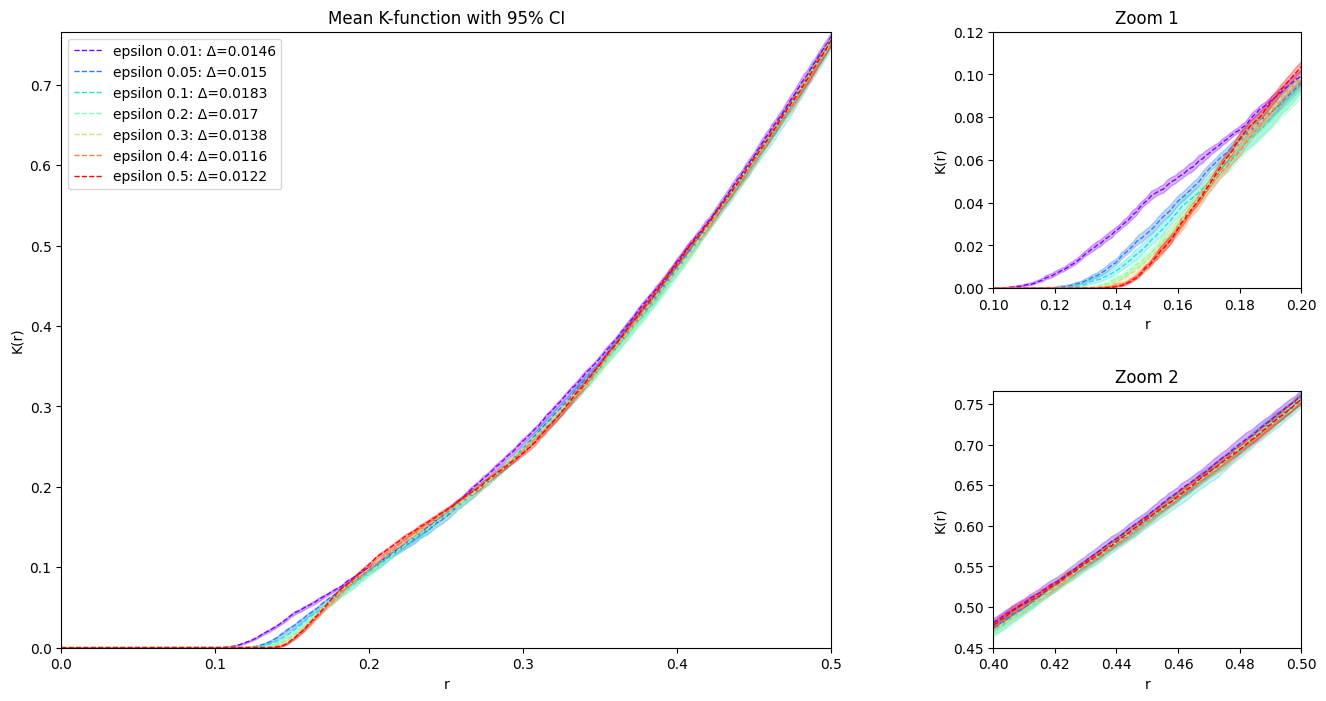

In [42]:
with open("K_mean_sd_lj.json", "r") as f:
    K_mean_sd = json.load(f)

colors = plt.cm.rainbow(np.linspace(0, 1, len(K_mean_sd)))
ymin, ymax = float("inf"), float("-inf")

# Get y-limits
for k in K_mean_sd.values():
    ymin = min(ymin, min(k["lower"]))
    ymax = max(ymax, max(k["upper"]))

# Create figure with 2 columns and 2 rows
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# === MAIN PLOT ===
ax_main = fig.add_subplot(gs[:, 0])  # Span both rows
ax_main.set_xlim(0, 0.5)
ax_main.set_ylim(ymin, ymax)
ax_main.set_xlabel("r")
ax_main.set_ylabel("K(r)")
ax_main.set_title("Mean K-function with 95% CI")

legend_texts = []

for i, (param_label, data) in enumerate(K_mean_sd.items()):
    r_vals = data["r"]
    mean_vals = data["mean"]
    upper_vals = data["upper"]
    lower_vals = data["lower"]
    color = colors[i]

    # Confidence band
    ax_main.fill_between(r_vals, lower_vals, upper_vals, color=color, alpha=0.3)
    
    # Mean line
    delta = round(max(np.array(upper_vals) - np.array(lower_vals)), 4)
    label = f"epsilon {param_label}: Δ={delta}"
    ax_main.plot(r_vals, mean_vals, color=color, lw=1, linestyle="--", label=label)

ax_main.legend(loc="upper left")

# === ZOOM PLOT 1 (top right) ===
ax_zoom1 = fig.add_subplot(gs[0, 1])
ax_zoom1.set_xlim(0.1, 0.2)
ax_zoom1.set_ylim(ymin, 0.12)
ax_zoom1.set_title("Zoom 1")
ax_zoom1.set_xlabel("r")
ax_zoom1.set_ylabel("K(r)")
for i, (param_label, data) in enumerate(K_mean_sd.items()):
    r_vals = data["r"]
    mean_vals = data["mean"]
    upper_vals = data["upper"]
    lower_vals = data["lower"]
    color = colors[i]
    ax_zoom1.fill_between(r_vals, lower_vals, upper_vals, color=color, alpha=0.3)
    ax_zoom1.plot(r_vals, mean_vals, color=color, lw=1, linestyle="--")

# === ZOOM PLOT 2 (bottom right) ===
ax_zoom2 = fig.add_subplot(gs[1, 1])
ax_zoom2.set_xlim(0.4, 0.5)
ax_zoom2.set_ylim(0.45, ymax)
ax_zoom2.set_title("Zoom 2")
ax_zoom2.set_xlabel("r")
ax_zoom2.set_ylabel("K(r)")
for i, (param_label, data) in enumerate(K_mean_sd.items()):
    r_vals = data["r"]
    mean_vals = data["mean"]
    upper_vals = data["upper"]
    lower_vals = data["lower"]
    color = colors[i]
    ax_zoom2.fill_between(r_vals, lower_vals, upper_vals, color=color, alpha=0.3)
    ax_zoom2.plot(r_vals, mean_vals, color=color, lw=1, linestyle="--")

plt.tight_layout()
plt.show()

/tmp/ipykernel_3924950/1232219872.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


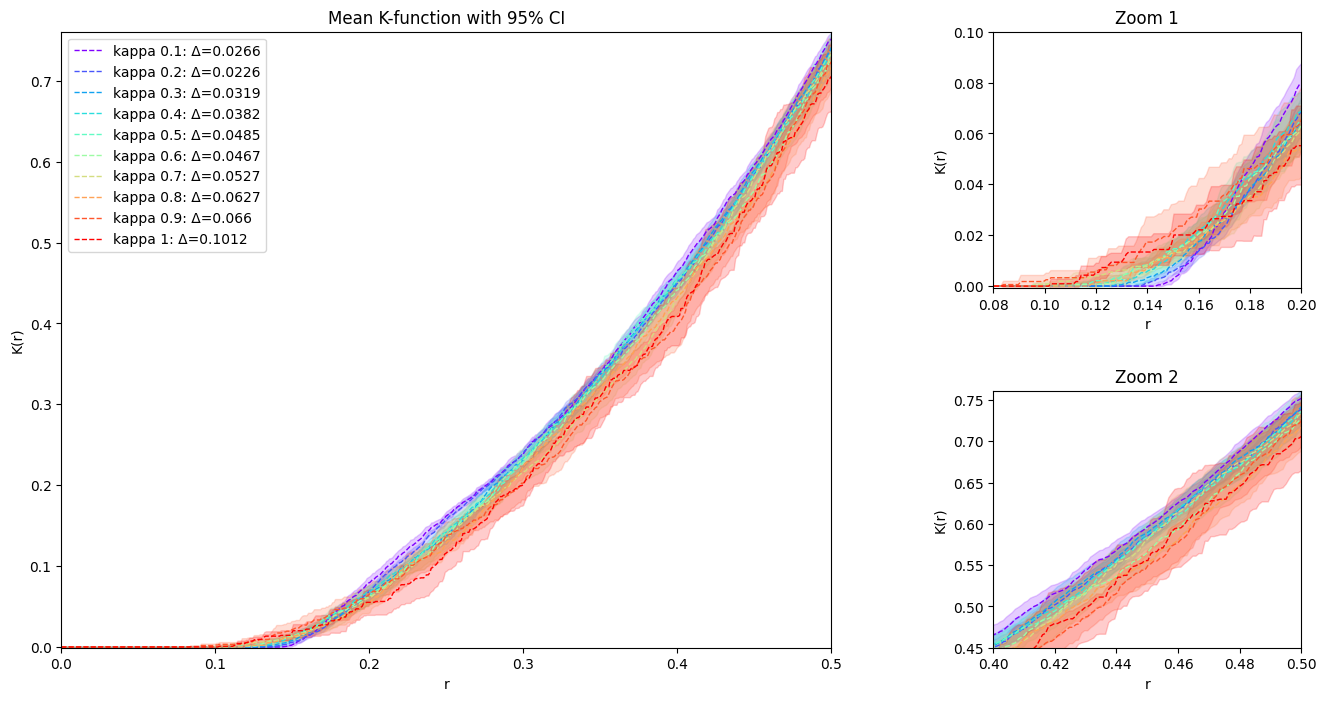

In [4]:
with open("K_mean_sd_sftcr.json", "r") as f:
    K_mean_sd = json.load(f)

colors = plt.cm.rainbow(np.linspace(0, 1, len(K_mean_sd)))
ymin, ymax = float("inf"), float("-inf")

# Get y-limits
for k in K_mean_sd.values():
    ymin = min(ymin, min(k["lower"]))
    ymax = max(ymax, max(k["upper"]))

# Create figure with 2 columns and 2 rows
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# === MAIN PLOT ===
ax_main = fig.add_subplot(gs[:, 0])  # Span both rows
ax_main.set_xlim(0, 0.5)
ax_main.set_ylim(ymin, ymax)
ax_main.set_xlabel("r")
ax_main.set_ylabel("K(r)")
ax_main.set_title("Mean K-function with 95% CI")

legend_texts = []

for i, (param_label, data) in enumerate(K_mean_sd.items()):
    r_vals = data["r"]
    mean_vals = data["mean"]
    upper_vals = data["upper"]
    lower_vals = data["lower"]
    color = colors[i]

    # Confidence band
    ax_main.fill_between(r_vals, lower_vals, upper_vals, color=color, alpha=0.2)
    
    # Mean line
    delta = round(max(np.array(upper_vals) - np.array(lower_vals)), 4)
    label = f"kappa {param_label}: Δ={delta}"
    ax_main.plot(r_vals, mean_vals, color=color, lw=1, linestyle="--", label=label)

ax_main.legend(loc="upper left")

# === ZOOM PLOT 1 (top right) ===
ax_zoom1 = fig.add_subplot(gs[0, 1])
ax_zoom1.set_xlim(0.08, 0.2)
ax_zoom1.set_ylim(ymin, 0.1)
ax_zoom1.set_title("Zoom 1")
ax_zoom1.set_xlabel("r")
ax_zoom1.set_ylabel("K(r)")
for i, (param_label, data) in enumerate(K_mean_sd.items()):
    r_vals = data["r"]
    mean_vals = data["mean"]
    upper_vals = data["upper"]
    lower_vals = data["lower"]
    color = colors[i]
    ax_zoom1.fill_between(r_vals, lower_vals, upper_vals, color=color, alpha=0.2)
    ax_zoom1.plot(r_vals, mean_vals, color=color, lw=1, linestyle="--")

# === ZOOM PLOT 2 (bottom right) ===
ax_zoom2 = fig.add_subplot(gs[1, 1])
ax_zoom2.set_xlim(0.4, 0.5)
ax_zoom2.set_ylim(0.45, ymax)
ax_zoom2.set_title("Zoom 2")
ax_zoom2.set_xlabel("r")
ax_zoom2.set_ylabel("K(r)")
for i, (param_label, data) in enumerate(K_mean_sd.items()):
    r_vals = data["r"]
    mean_vals = data["mean"]
    upper_vals = data["upper"]
    lower_vals = data["lower"]
    color = colors[i]
    ax_zoom2.fill_between(r_vals, lower_vals, upper_vals, color=color, alpha=0.2)
    ax_zoom2.plot(r_vals, mean_vals, color=color, lw=1, linestyle="--")

plt.tight_layout()
plt.show()

In [13]:
def load_K_full(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    eps_labels = list(data.keys())
    r = np.array(data[eps_labels[0]]["r"], dtype=float)
    groups = {}
    for eps in eps_labels:
        curves_obj = data[eps]["curves"]
        
        # Case 1: dict of simulation -> list of values
        if isinstance(curves_obj, dict) and all(isinstance(v, list) for v in curves_obj.values()):
            k_matrix = np.column_stack(curves_obj.values()).T  # (nsim, n_r)
        
        # Case 2: list of lists
        elif isinstance(curves_obj, list) and all(isinstance(row, list) for row in curves_obj):
            arr = np.array(curves_obj, dtype=float)
            if arr.shape[1] == r.size:
                k_matrix = arr
            elif arr.shape[0] == r.size:
                k_matrix = arr.T
            else:
                raise ValueError(f"Unexpected curves shape {arr.shape} for eps {eps}")
        
        # Case 3: list of dicts (data.frame rows)
        elif isinstance(curves_obj, list) and all(isinstance(row, dict) for row in curves_obj):
            rows = [list(row.values()) for row in curves_obj]
            arr = np.array(rows, dtype=float)
            if arr.shape[1] == r.size:
                k_matrix = arr
            elif arr.shape[0] == r.size:
                k_matrix = arr.T
            else:
                raise ValueError(f"Unexpected curves shape {arr.shape} for eps {eps}")
        
        else:
            raise ValueError(f"Unsupported curves format for eps {eps}")
        
        groups[eps] = k_matrix
    return r, groups

def observed_stats(groups):
    eps_labels = list(groups.keys())
    group_means = {eps: groups[eps].mean(axis=0) for eps in eps_labels}  # (n_r,)
    all_means = np.vstack([group_means[eps] for eps in eps_labels])  # (n_eps, n_r)
    overall_mean = all_means.mean(axis=0)  # (n_r,)
    stats = {eps: float(np.max(np.abs(group_means[eps] - overall_mean))) for eps in eps_labels}
    return stats, group_means, overall_mean

def permutation_test_vs_last(groups, n_perm=5000):
    eps_labels = list(groups.keys())
    nsim = groups[eps_labels[0]].shape[0]
    n_eps = len(eps_labels)
    n_r = groups[eps_labels[0]].shape[1]

    last_idx = n_eps - 1
    last_label = eps_labels[last_idx]

    results = {}
    obs_stats = {}

    for gi in range(n_eps - 1):
        group_label = eps_labels[gi]

        # Get the two groups' data
        data1 = groups[group_label]
        data2 = groups[last_label]

        # Observed statistic
        mu1 = data1.mean(axis=0)
        mu2 = data2.mean(axis=0)
        T_obs = float(np.max(np.abs(mu1 - mu2)))
        obs_stats[group_label] = T_obs

        # Combine and permute
        pooled = np.vstack([data1, data2])
        labels = np.array([0]*nsim + [1]*nsim)

        null_count = 0
        for _ in range(n_perm):
            perm = np.random.permutation(len(labels))
            perm_labels = labels[perm]

            mu1_perm = pooled[perm_labels == 0].mean(axis=0)
            mu2_perm = pooled[perm_labels == 1].mean(axis=0)

            T_perm = np.max(np.abs(mu1_perm - mu2_perm))
            if T_perm >= T_obs:
                null_count += 1

        pval = (null_count + 1) / (n_perm + 1)
        results[group_label] = pval

    return results, obs_stats


In [14]:
json_path = "K_full_curves_lj.json"
n_perm = 5000
random_seed = 42
alpha = 0.05       

In [15]:
r, groups = load_K_full(json_path)
pvals, obs_stats = permutation_test_vs_last(groups, n_perm=n_perm)

print("\nPermutation test results (alpha = {:.3f}):".format(alpha))
print("{:>8} {:>12} {:>12} {:>8}".format("Epsilon", "T_obs", "p-value", "Sig?"))
for eps in sorted(pvals, key=lambda x: float(x)):
    sig = "YES" if pvals[eps] < alpha else "NO"
    print(f"{eps:>8} {obs_stats[eps]:12.6g} {pvals[eps]:12.4g} {sig:>8}")


Permutation test results (alpha = 0.050):
 Epsilon        T_obs      p-value     Sig?
    0.01    0.0314684       0.0002      YES
    0.05    0.0168947    0.0009998      YES
     0.1    0.0116263      0.08758       NO
     0.2    0.0131737       0.0136      YES
     0.3   0.00877368        0.189       NO
     0.4   0.00800526       0.2328       NO


/tmp/ipykernel_1515408/1544449033.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


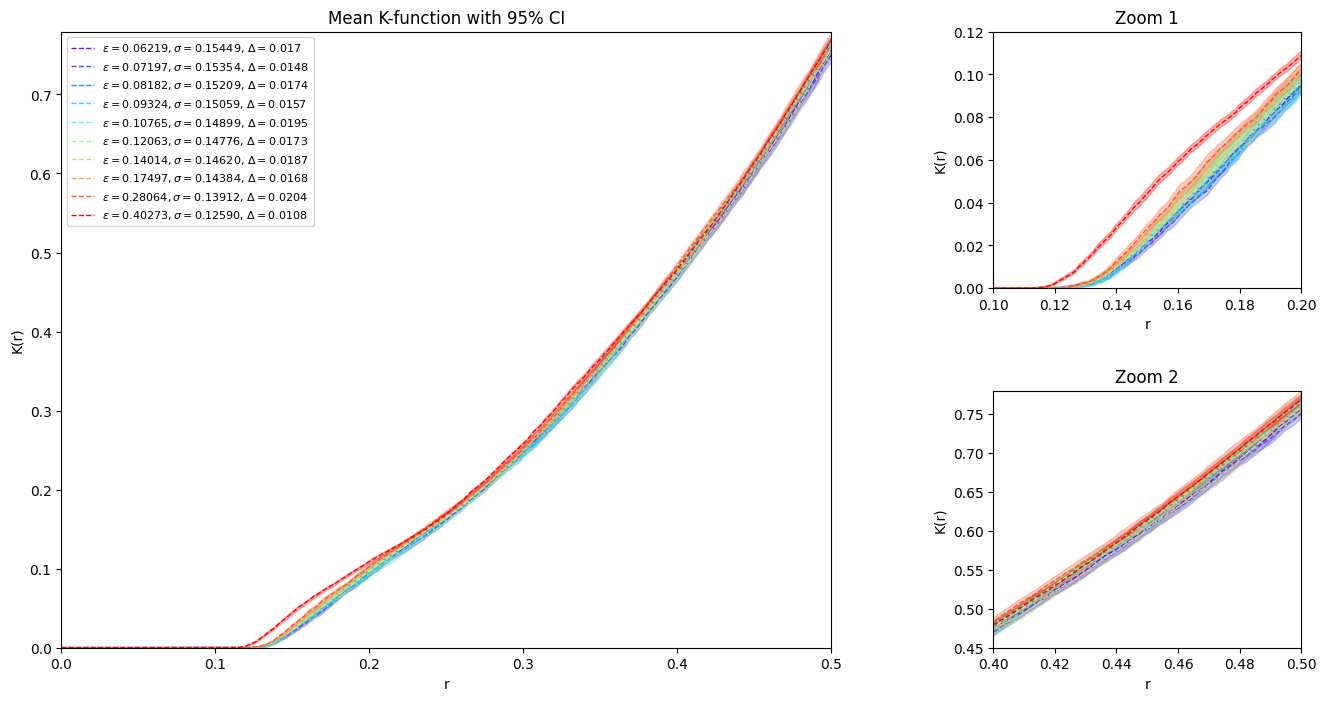

In [8]:
# Load data
with open("K_mean_sd_lj_grid.json", "r") as f:
    K_mean_sd = json.load(f)

# --- Sort by epsilon ---
def extract_eps(param_label):
    # param_label = "eps_0.01992_sig_0.17047"
    return float(param_label.split("_")[1])

sorted_items = sorted(K_mean_sd.items(), key=lambda x: extract_eps(x[0]))

colors = plt.cm.rainbow(np.linspace(0, 1, len(sorted_items)))

# Determine y-limits
ymin, ymax = float("inf"), float("-inf")
for _, k in sorted_items:
    ymin = min(ymin, min(k["lower"]))
    ymax = max(ymax, max(k["upper"]))

# Create figure
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# === MAIN PLOT ===
ax_main = fig.add_subplot(gs[:, 0])
ax_main.set_xlim(0, 0.5)
ax_main.set_ylim(ymin, ymax)
ax_main.set_xlabel("r")
ax_main.set_ylabel("K(r)")
ax_main.set_title("Mean K-function with 95% CI")

for i, (param_label, data) in enumerate(sorted_items):
    r_vals = np.array(data["r"])
    mean_vals = np.array(data["mean"])
    lower_vals = np.array(data["lower"])
    upper_vals = np.array(data["upper"])
    color = colors[i]

    ax_main.fill_between(r_vals, lower_vals, upper_vals, color=color, alpha=0.3)

    # Extract epsilon and sigma
    parts = param_label.split("_")
    eps_val = float(parts[1])
    sig_val = float(parts[3])

    delta = round(max(upper_vals - lower_vals), 4)
    label = rf"$\epsilon={eps_val:.5f}, \sigma={sig_val:.5f}$, $\Delta={delta}$"
    ax_main.plot(r_vals, mean_vals, color=color, lw=1, linestyle="--", label=label)

ax_main.legend(loc="upper left", fontsize=8)

# === ZOOM 1 (top right) ===
ax_zoom1 = fig.add_subplot(gs[0, 1])
ax_zoom1.set_xlim(0.1, 0.2)
ax_zoom1.set_ylim(ymin, 0.12)
ax_zoom1.set_title("Zoom 1")
ax_zoom1.set_xlabel("r")
ax_zoom1.set_ylabel("K(r)")
for i, (_, data) in enumerate(sorted_items):
    r_vals = np.array(data["r"])
    mean_vals = np.array(data["mean"])
    lower_vals = np.array(data["lower"])
    upper_vals = np.array(data["upper"])
    color = colors[i]
    ax_zoom1.fill_between(r_vals, lower_vals, upper_vals, color=color, alpha=0.3)
    ax_zoom1.plot(r_vals, mean_vals, color=color, lw=1, linestyle="--")

# === ZOOM 2 (bottom right) ===
ax_zoom2 = fig.add_subplot(gs[1, 1])
ax_zoom2.set_xlim(0.4, 0.5)
ax_zoom2.set_ylim(0.45, ymax)
ax_zoom2.set_title("Zoom 2")
ax_zoom2.set_xlabel("r")
ax_zoom2.set_ylabel("K(r)")
for i, (_, data) in enumerate(sorted_items):
    r_vals = np.array(data["r"])
    mean_vals = np.array(data["mean"])
    lower_vals = np.array(data["lower"])
    upper_vals = np.array(data["upper"])
    color = colors[i]
    ax_zoom2.fill_between(r_vals, lower_vals, upper_vals, color=color, alpha=0.3)
    ax_zoom2.plot(r_vals, mean_vals, color=color, lw=1, linestyle="--")

plt.tight_layout()
plt.show()

In [16]:
json_path = "K_full_curves_lj_grid.json"
n_perm = 5000
random_seed = 42
alpha = 0.05    

In [18]:
r, groups = load_K_full(json_path)
pvals, obs_stats = permutation_test_vs_last(groups, n_perm=n_perm)

print("\nPermutation test results (alpha = {:.3f}):".format(alpha))
print("{:>8} {:>8} {:>12} {:>8} {:>8}".format("Epsilon", "Sigma", "T_obs", "p-value", "Sig?"))

for key in pvals:
    parts = key.split("_")
    eps_val = float(parts[1])
    sig_val = float(parts[3])
    sig = "YES" if pvals[key] < alpha else "NO"
    print(f"{eps_val:8.5f} {sig_val:8.5f} {obs_stats[key]:12.6g} {pvals[key]:12.4g} {sig:>8}")


Permutation test results (alpha = 0.050):
 Epsilon    Sigma        T_obs  p-value     Sig?
 0.40273  0.12590      0.02475       0.0002      YES
 0.28064  0.13912     0.014895      0.06059       NO
 0.17497  0.14384     0.008975       0.3515       NO
 0.14014  0.14620      0.00506       0.9674       NO
 0.12063  0.14776      0.01015       0.2358       NO
 0.10765  0.14899      0.01362      0.06839       NO
 0.09324  0.15059      0.00938       0.3095       NO
 0.08182  0.15209      0.00688       0.7291       NO
 0.07197  0.15354      0.00729       0.6227       NO
